# Tuning Script :D

In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#
from Calculations_Functions import proportions_from_filename, metrics_table
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')

In [7]:
def plot_cumulative_watercolumn_particles(filename, release_freq, output_res, plot=True):
    # Load data
    data = xr.open_dataset(filename, engine='zarr')
    time = data.time[0, 0].values 
    start_time = pd.to_datetime(time)

    # Count particles in the water column (status 1, 2, or 3)
    go_back = data.status.shape[1]
    number_in_watercolumn = np.zeros(go_back)
    for it in range(go_back):
        positive = data.status[:, it][data.status[:, it] > 0]
        number_in_watercolumn[it] = positive.values[positive.values < 4].shape[0]

    # Create time index
    time_index = pd.date_range(start=start_time, periods=data.time.shape[1], freq=f'{output_res}h')

    # Get number of steps in 30 days
    steps_per_day = int(24 / output_res)
    steps_30_days = 30 * steps_per_day

    # Start with zero and accumulate the pulse
    cumulative = np.copy(number_in_watercolumn)
    for i in range(0, go_back, steps_30_days):
        pulse_len = go_back - i
        cumulative[i:] += number_in_watercolumn[:pulse_len]

    # Theoretical exponential model
    def exp_model(t, C0, time_decay):
        alpha = 1 / (time_decay * 365 * 86400 / (3600 * output_res))
        return C0 * (1 - np.exp(-alpha * t))

    # Fit the model to your data
    tt = np.arange(0, len(data.time[1]))
    popt, pcov = curve_fit(exp_model, tt, cumulative, p0=[1.0, 1.0])
    C0_fit, decay_fit = popt
    y_fit = exp_model(tt, C0_fit, decay_fit)

    # Create output DataFrame
    C = (365 * 86400) / release_freq    
    df_out = pd.DataFrame({
        'goal': y_fit,
        'cumulative': cumulative
    }, index=time_index)
    df_out.index.name = 'datetime'

    # Plotting
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(15, 4))
        ax.plot(df_out.index, df_out['cumulative'], 'b', label='Cumulative Curve (30-day pulse repetition)')
        ax.plot(df_out.index, df_out['goal'], 'k', label=rf'Theoretical Curve ($\tau$ = {decay_fit:.2f} years)')
        ax.set_title('Cumulative Water Column Particles vs Theoretical Curve')
        ax.set_xlabel('Time')
        ax.set_ylabel('Particle Count')
        ax.grid()
        ax.legend(loc='upper left', fontsize=12)

        textstr = (
            f"Exponential Fit\n"
            f"C $\\cdot$ (1 - exp(- $\\alpha \\cdot$ t))\n"
            f"\n"
            f"Final Theoretical: {int(y_fit[-1])}\n"
            f"Final Cumulative: {int(cumulative[-1])}\n"
            f"Fitted Expected (C): {int(C0_fit)}\n"
            f"Expected Amount = {int(C)}\n"
            f"Fitted Decay Time ($\\tau$) = {decay_fit:.2f} years"
        )
        ax.text(0.87, 0.05, textstr,
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), ha='center')

    return df_out

# Simulations: 

- Ratio = $\textbf{0.2}$
- Sinking Velocity = $\textbf{5.52}$ m/hr
- $\tau_c = \textbf{0.025}$ Pa

In [5]:
filename1 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_025_ratio_0_2_sv_5.zarr'

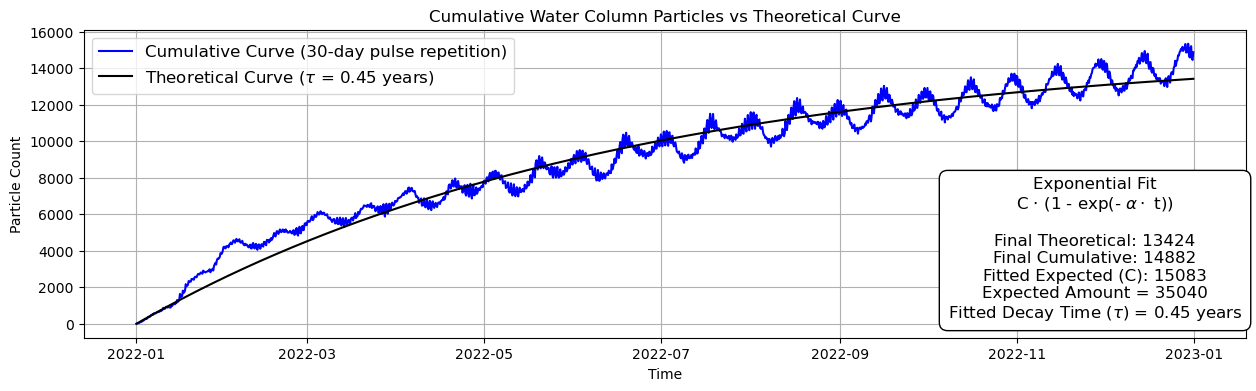

In [6]:
c_wc_1 = plot_cumulative_watercolumn_particles(filename = filename1, release_freq=900, output_res=6, plot=True)

In [7]:
run1 = proportions_from_filename(filename = filename1)
#
table1  = metrics_table(filename = filename1, plot = False)
#
water1, sediment1 =  run1['Sewage Water'] + run1['Colloidal Water'] + run1['Marine Water'] , run1['Sewage Sediment'] + run1['Colloidal Sediment'] + run1['Marine Sediment']

/tmp/ipykernel_194698/1721246246.py:66: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_194698/1721246246.py:67: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_194698/1721246246.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

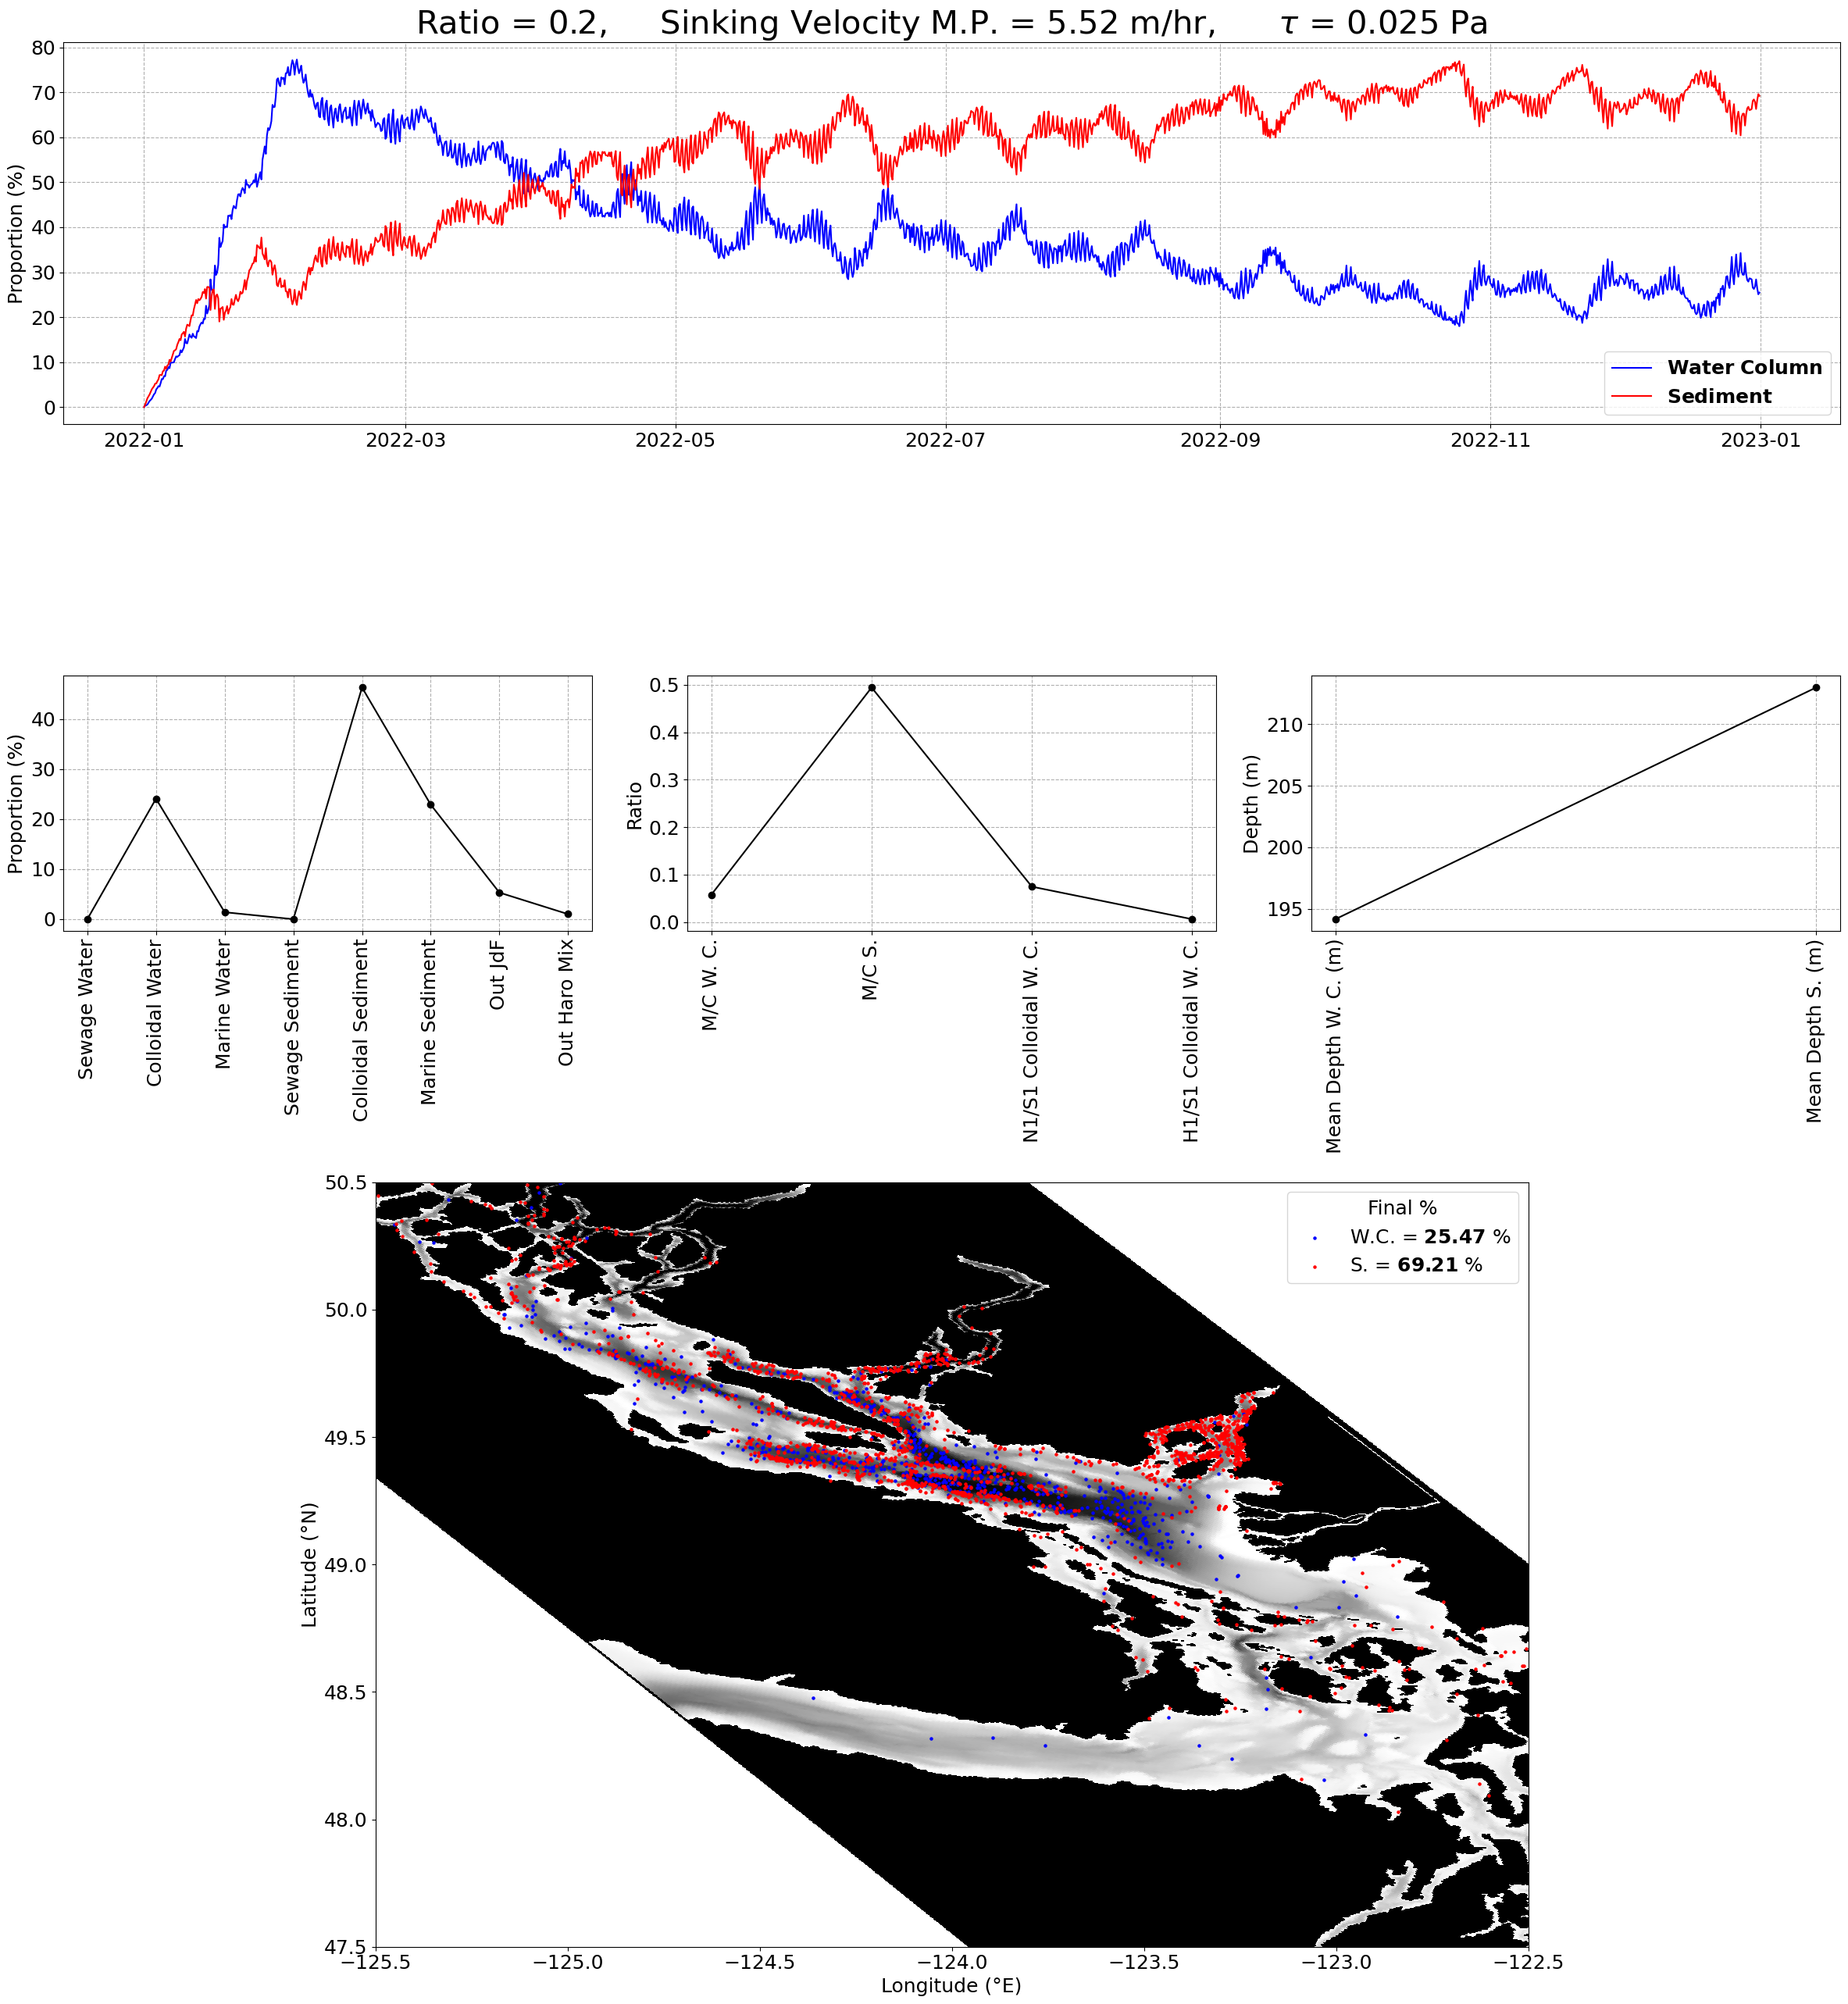

In [8]:
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
#
import matplotlib.gridspec as gridspec
#
data1 = xr.open_zarr(filename1)
wc1 = data1.where((data1.status < 4) & (data1.status > 0))
sed1 = data1.where((data1.status > 10))

#

plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water1, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment1, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.2,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.025 Pa', fontsize = 30)

# Middle left
ax3.plot(run1.columns[1:], run1.iloc[-1][1:].values, '-o', color='k', label='Abso/Deso = 0.012')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table1.columns[1:5], table1.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table1.columns[-2:], table1.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc1.lon[:,-1], wc1.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water1[-1], 2)}}}\ \%$")
ax6.scatter(sed1.lon[:,-1], sed1.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment1[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

- Ratio = $\textbf{0.1}$
- Sinking Velocity = $\textbf{5.52}$ m/hr
- $\tau_c = \textbf{0.02}$ Pa

In [7]:
filename2 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_02_ratio_0_1_sv_5.zarr'

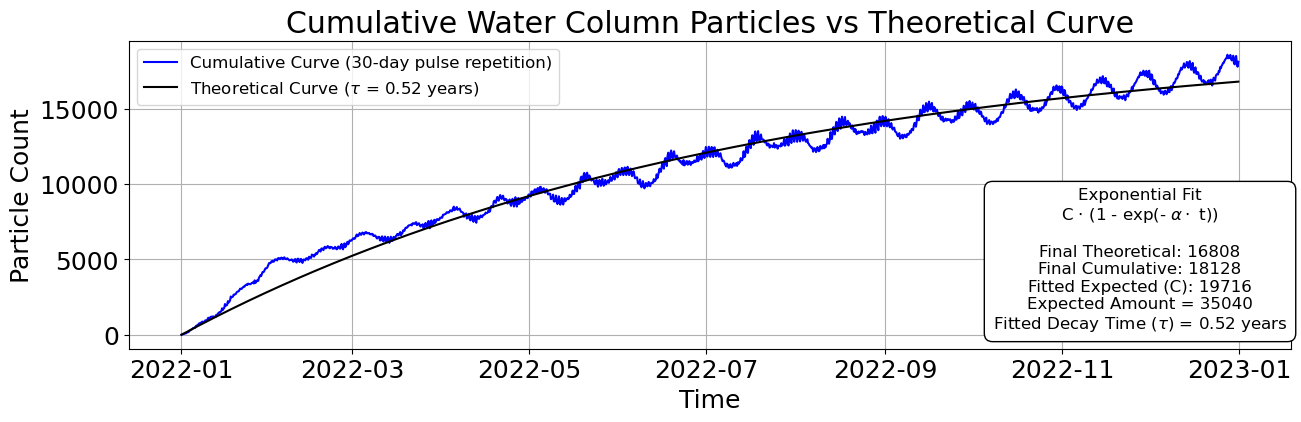

In [8]:
c_wc_2 = plot_cumulative_watercolumn_particles(filename = filename2, release_freq=900, output_res=6, plot=True)

In [9]:
run2 = proportions_from_filename(filename = filename2)
#
table2  = metrics_table(filename = filename2, plot = False)
#
water2, sediment2 =  run2['Sewage Water'] + run2['Colloidal Water'] + run2['Marine Water'] , run2['Sewage Sediment'] + run2['Colloidal Sediment'] + run2['Marine Sediment']

/tmp/ipykernel_1881652/2095809338.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_1881652/2095809338.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_1881652/2095809338.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

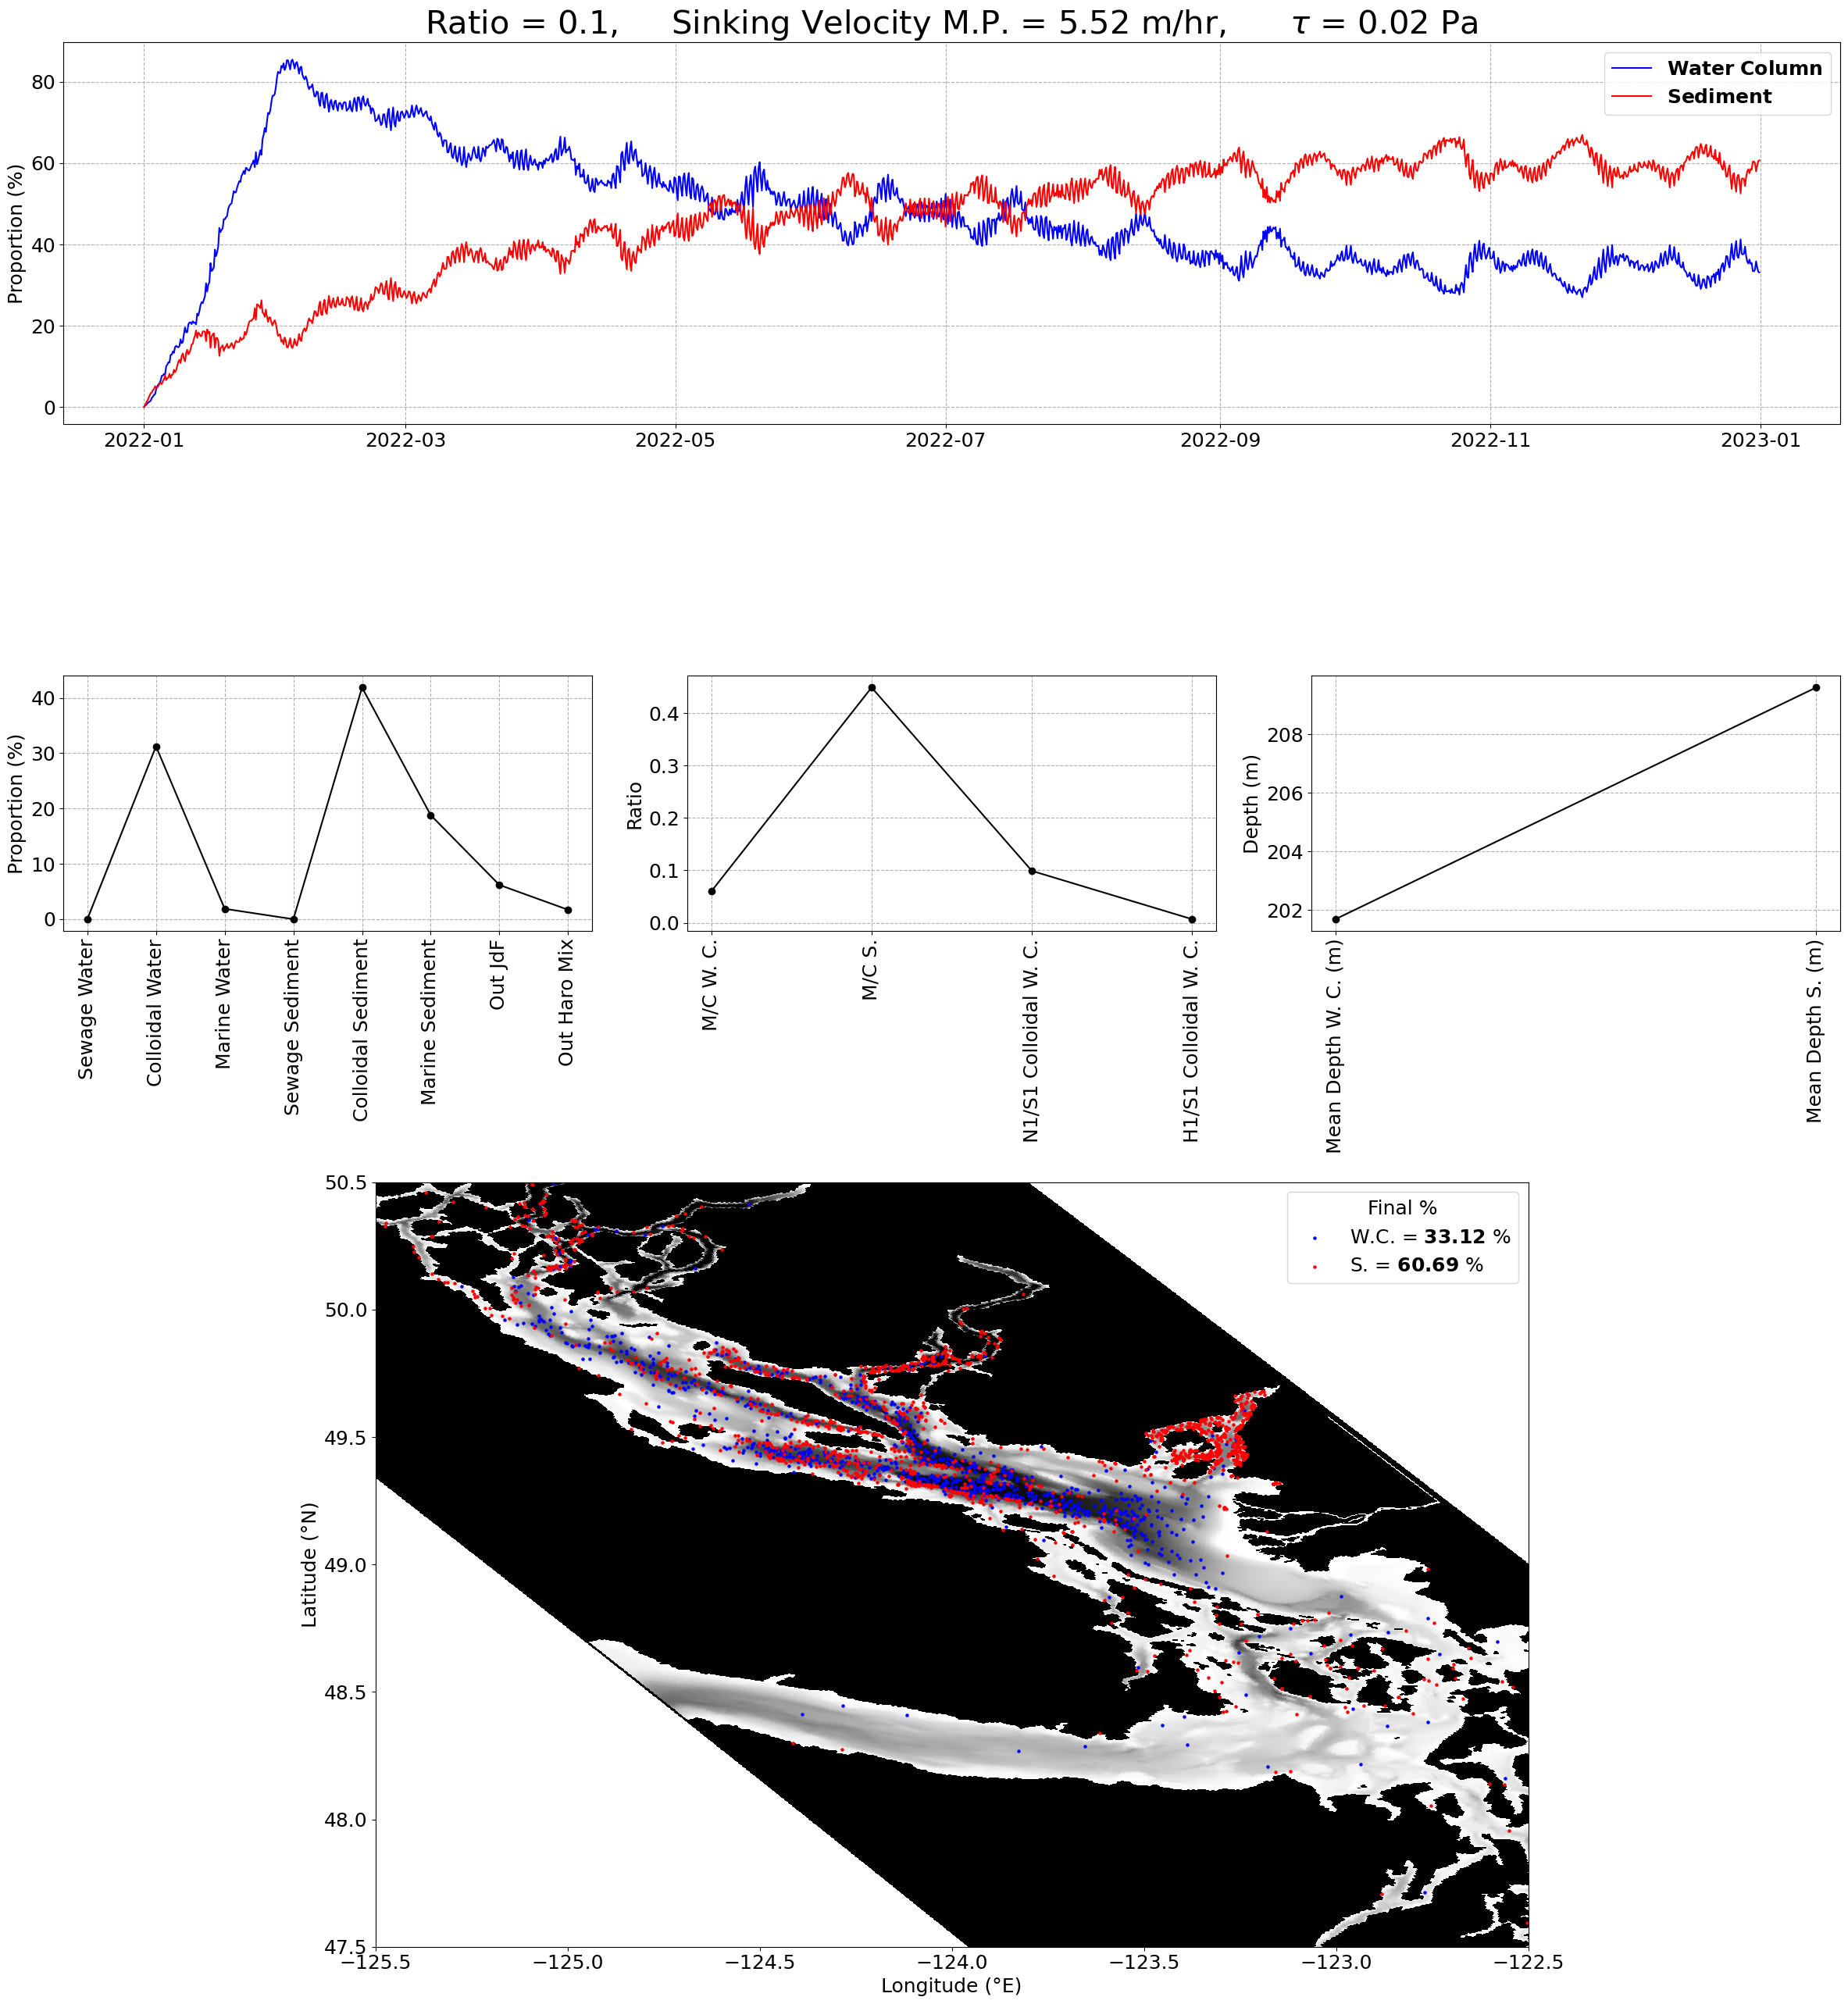

In [10]:
data2 = xr.open_zarr(filename2)
wc2 = data2.where((data2.status < 4) & (data2.status > 0))
sed2 = data2.where((data2.status > 10))

#

plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water2, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment2, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.1,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.02 Pa', fontsize = 30)

# Middle left
ax3.plot(run2.columns[1:], run2.iloc[-1][1:].values, '-o', color='k')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table2.columns[1:5], table2.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table2.columns[-2:], table2.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc2.lon[:,-1], wc2.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water2[-1], 2)}}}\ \%$")
ax6.scatter(sed2.lon[:,-1], sed2.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment2[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

- Ratio = $\textbf{0.1}$
- Sinking Velocity = $\textbf{5.52}$ m/hr
- $\tau_c = \textbf{0.01}$ Pa

In [11]:
filename3 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_1_sv_5.zarr'

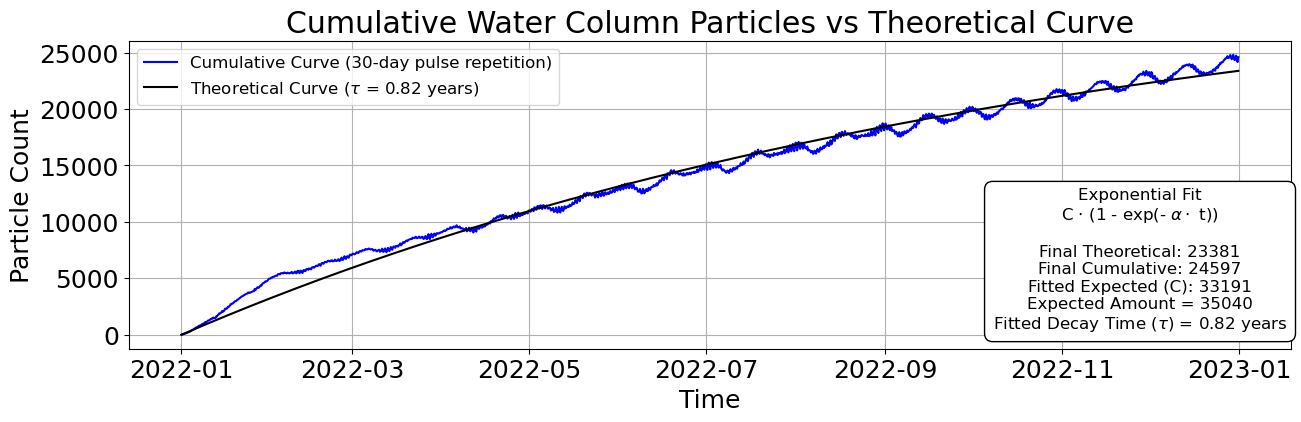

In [12]:
c_wc_3 = plot_cumulative_watercolumn_particles(filename = filename3, release_freq=900, output_res=6, plot=True)

In [13]:
run3 = proportions_from_filename(filename = filename3)
#
table3  = metrics_table(filename = filename3, plot = False)
#
water3, sediment3 =  run3['Sewage Water'] + run3['Colloidal Water'] + run3['Marine Water'] , run3['Sewage Sediment'] + run3['Colloidal Sediment'] + run3['Marine Sediment']

/tmp/ipykernel_1881652/1389058238.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_1881652/1389058238.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_1881652/1389058238.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

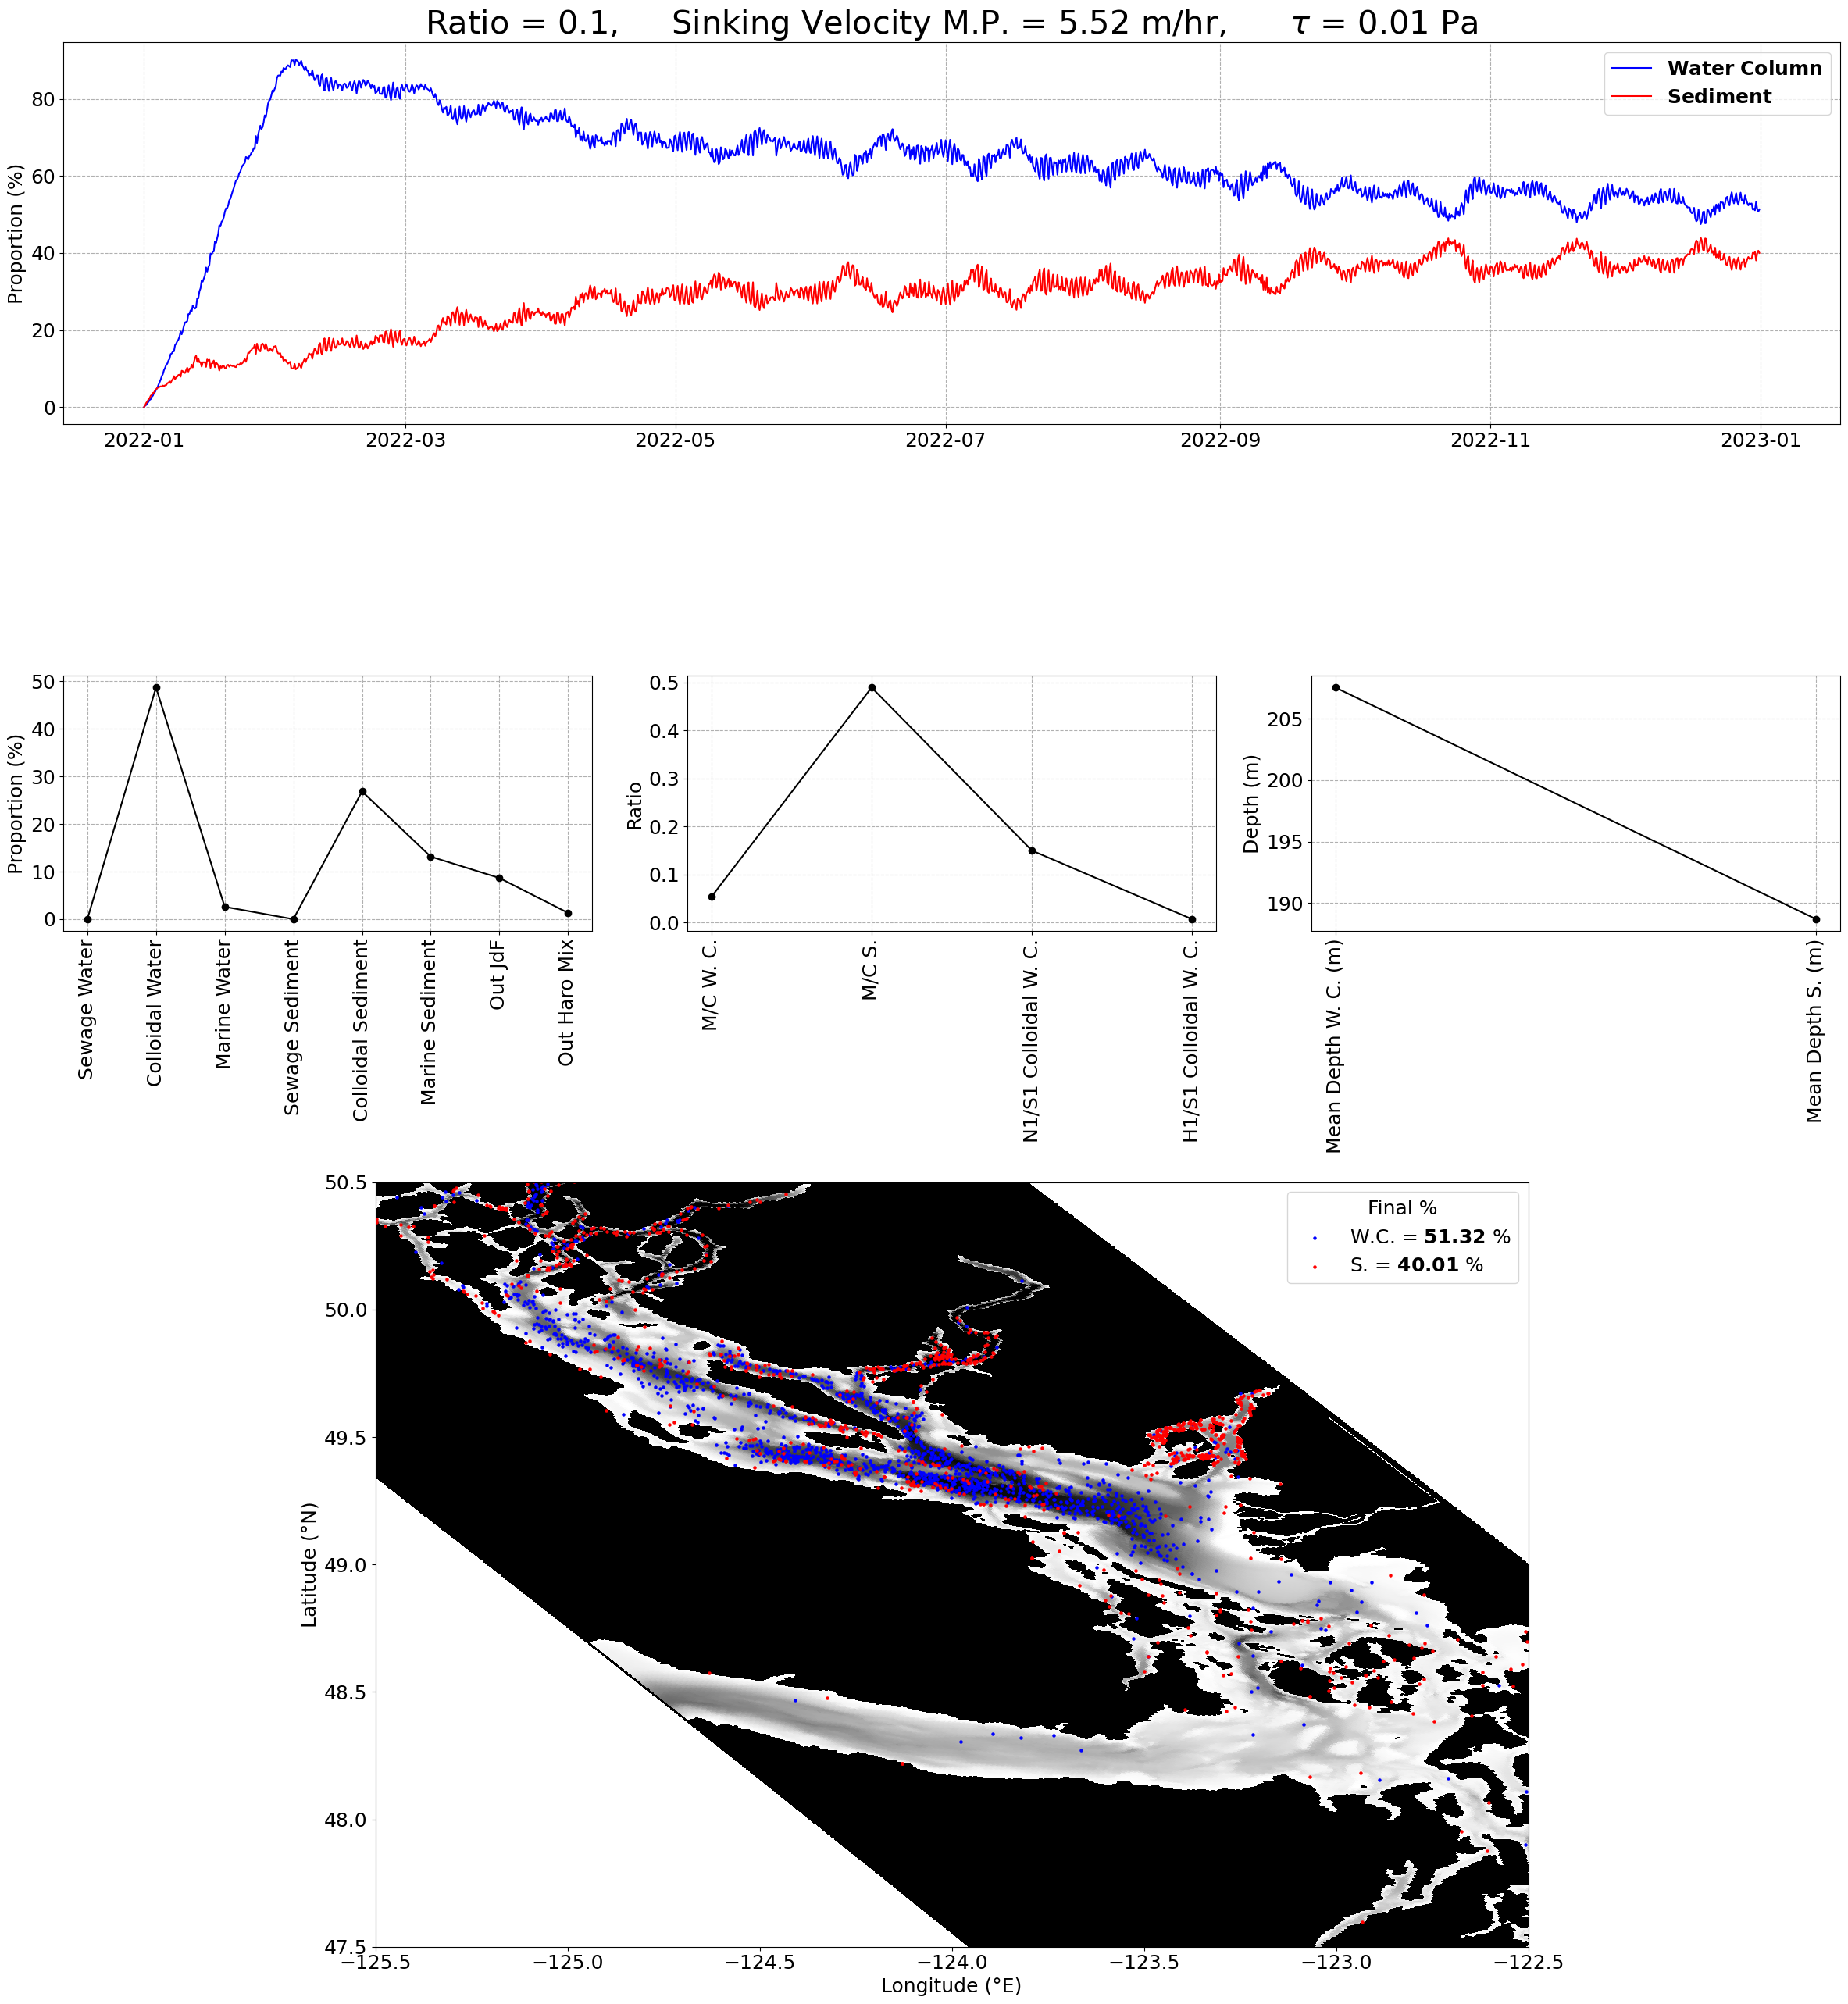

In [14]:
data3 = xr.open_zarr(filename3)
wc3 = data3.where((data3.status < 4) & (data3.status > 0))
sed3 = data3.where((data3.status > 10))

#

plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water3, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment3, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.1,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.01 Pa', fontsize = 30)

# Middle left
ax3.plot(run3.columns[1:], run3.iloc[-1][1:].values, '-o', color='k')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table3.columns[1:5], table3.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table3.columns[-2:], table3.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc3.lon[:,-1], wc3.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water3[-1], 2)}}}\ \%$")
ax6.scatter(sed3.lon[:,-1], sed3.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment3[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

Some more tuning attempts :D

- Ratio = $\textbf{0.1}$
- Sinking Velocity = $\textbf{5.52}$ m/hr
- $\tau_c = \textbf{0.01}$ Pa
- Absorption = 0.052

In [15]:
filename_AD1 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_1_sv_5_AD_0_052.zarr'

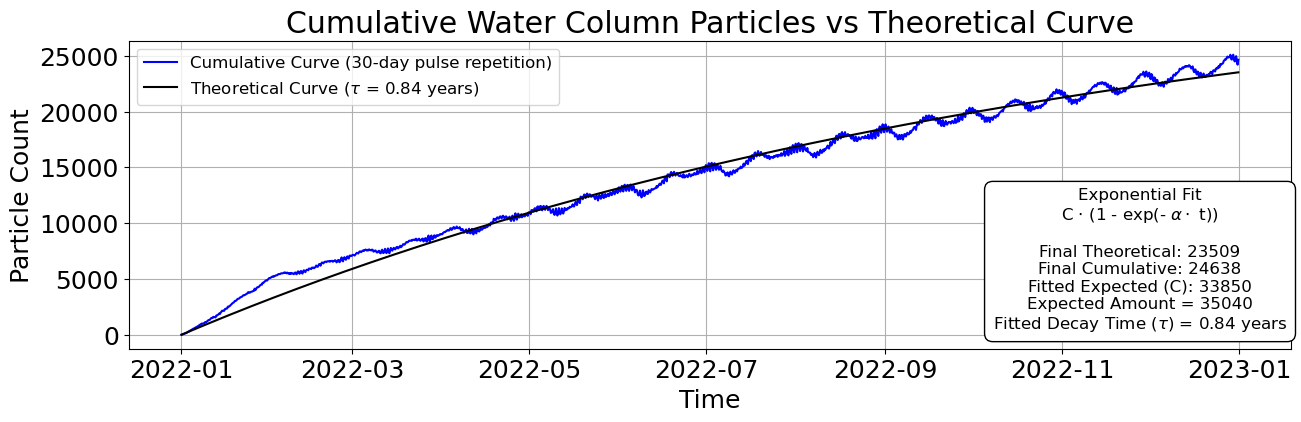

In [16]:
c_wc_AD1 = plot_cumulative_watercolumn_particles(filename = filename_AD1, release_freq=900, output_res=6, plot=True)

In [17]:
run_AD1 = proportions_from_filename(filename = filename_AD1)
#
table_AD1  = metrics_table(filename = filename_AD1, plot = False)
#
water_AD1, sediment_AD1 =  run_AD1['Sewage Water'] + run_AD1['Colloidal Water'] + run_AD1['Marine Water'] , run_AD1['Sewage Sediment'] + run_AD1['Colloidal Sediment'] + run_AD1['Marine Sediment']

/tmp/ipykernel_1881652/1687726349.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_1881652/1687726349.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_1881652/1687726349.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

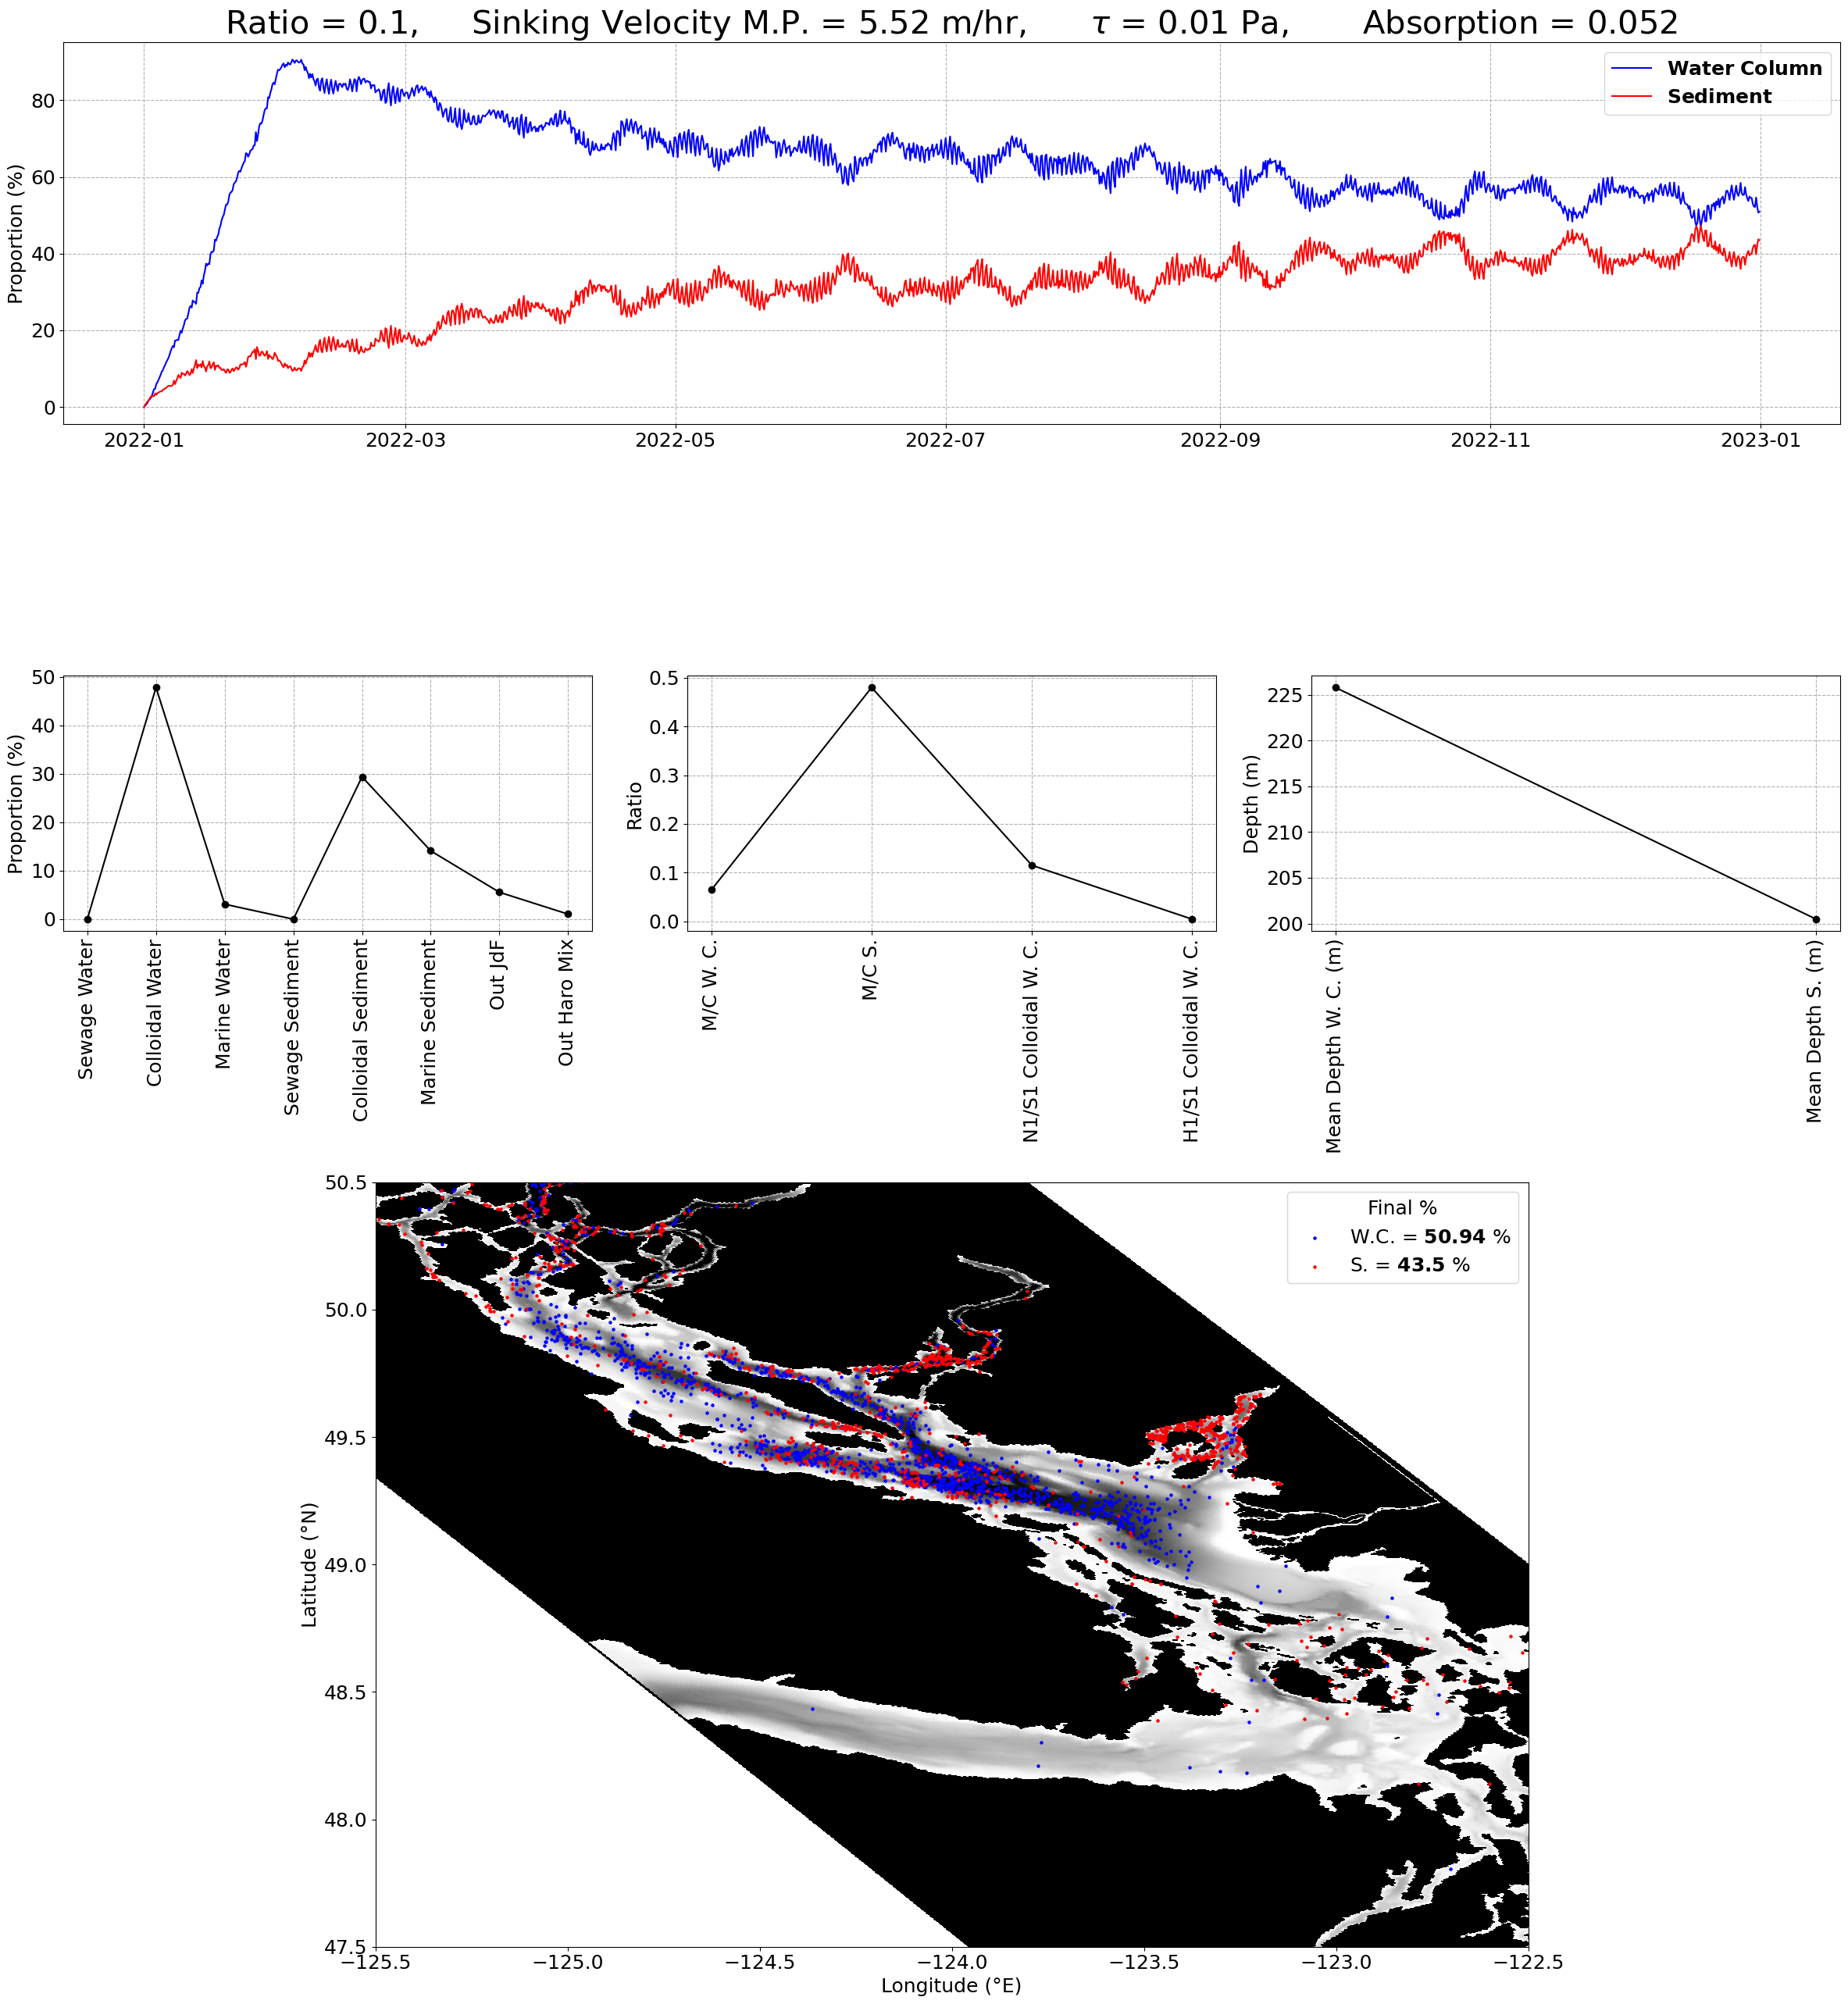

In [18]:
data_AD1 = xr.open_zarr(filename_AD1)
wc_AD1 = data_AD1.where((data_AD1.status < 4) & (data_AD1.status > 0))
sed_AD1 = data_AD1.where((data_AD1.status > 10))

#

plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water_AD1, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment_AD1, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.1,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.01 Pa,       Absorption = 0.052', fontsize = 30)

# Middle left
ax3.plot(run_AD1.columns[1:], run_AD1.iloc[-1][1:].values, '-o', color='k')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table_AD1.columns[1:5], table_AD1.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table_AD1.columns[-2:], table_AD1.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc_AD1.lon[:,-1], wc_AD1.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water_AD1[-1], 2)}}}\ \%$")
ax6.scatter(sed_AD1.lon[:,-1], sed_AD1.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment_AD1[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

- Ratio = $\textbf{0.1}$
- Sinking Velocity = $\textbf{5.52}$ m/hr
- $\tau_c = \textbf{0.01}$ Pa
- Absorption = 0.024

In [19]:
filename_AD2 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_1_sv_5_AD_0_024.zarr'

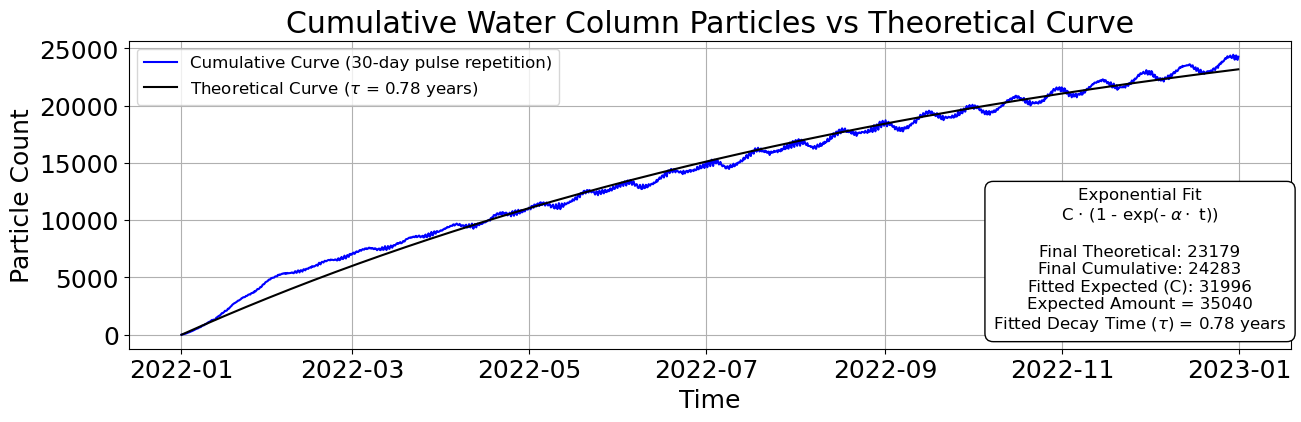

In [20]:
c_wc_AD2 = plot_cumulative_watercolumn_particles(filename = filename_AD2, release_freq=900, output_res=6, plot=True)

In [21]:
run_AD2 = proportions_from_filename(filename = filename_AD2)
#
table_AD2  = metrics_table(filename = filename_AD2, plot = False)
#
water_AD2, sediment_AD2 =  run_AD2['Sewage Water'] + run_AD2['Colloidal Water'] + run_AD2['Marine Water'] , run_AD2['Sewage Sediment'] + run_AD2['Colloidal Sediment'] + run_AD2['Marine Sediment']

/tmp/ipykernel_1881652/1379291144.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_1881652/1379291144.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_1881652/1379291144.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

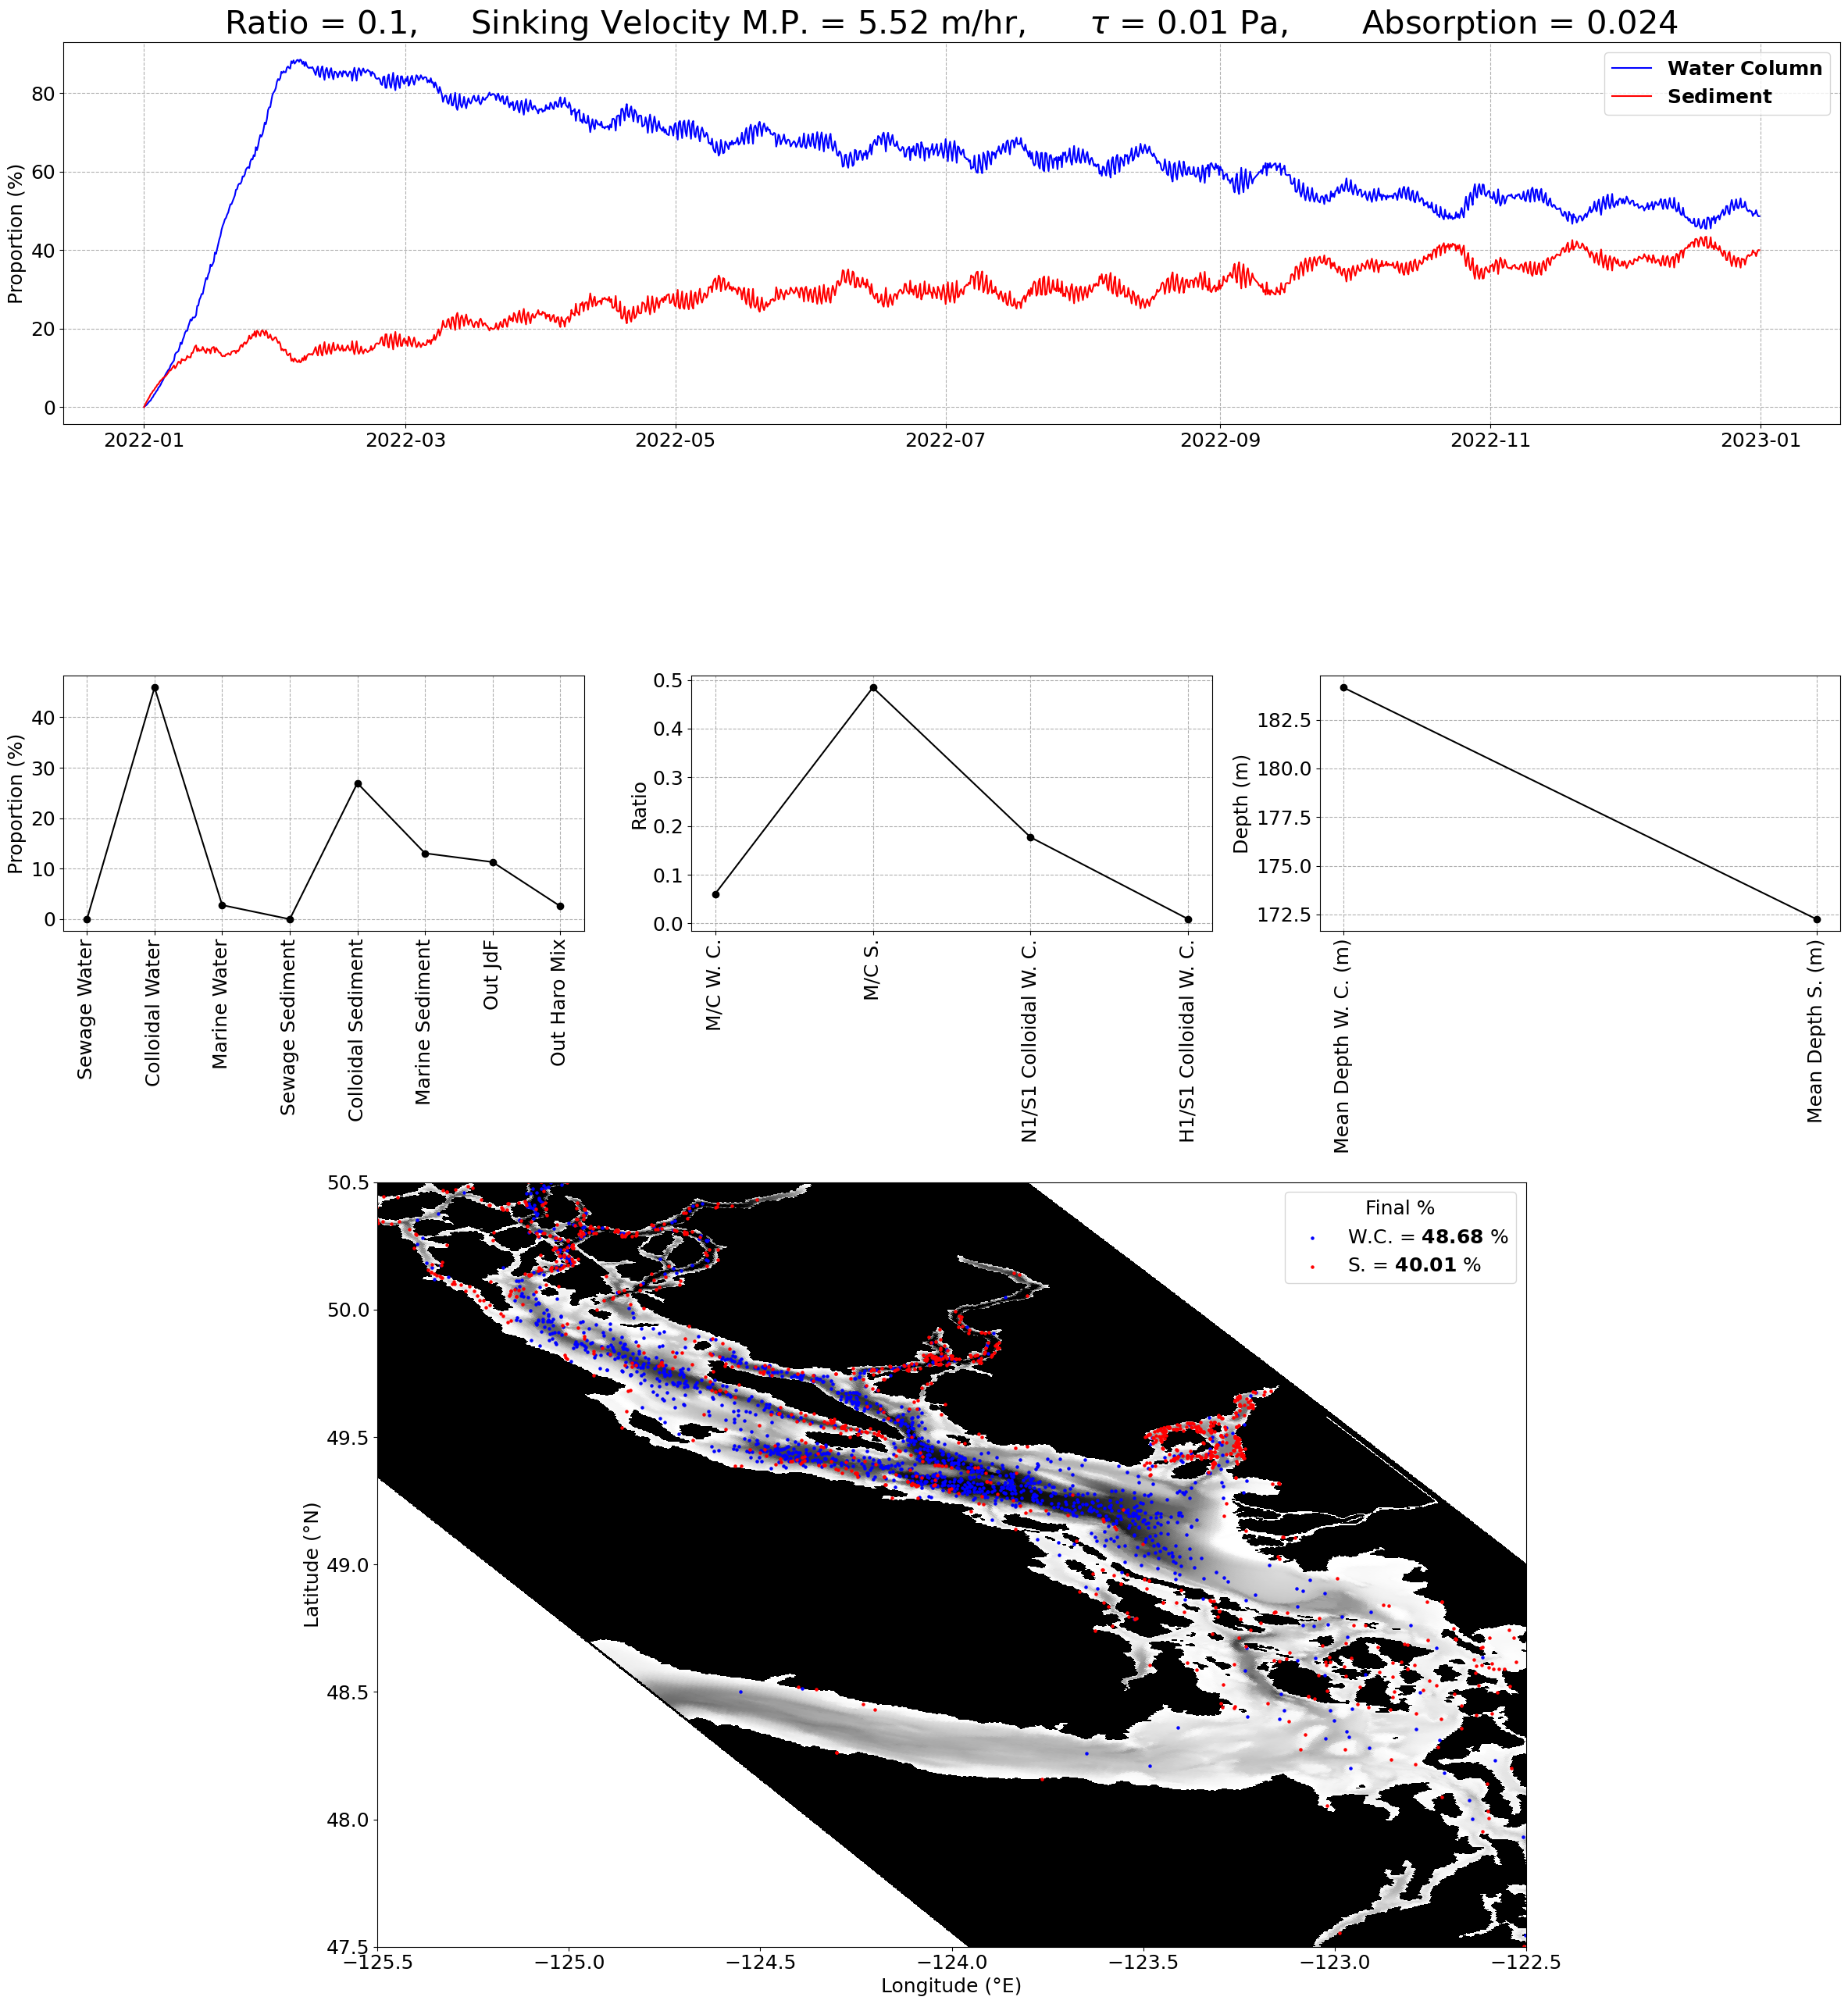

In [22]:
data_AD2 = xr.open_zarr(filename_AD2)
wc_AD2 = data_AD2.where((data_AD2.status < 4) & (data_AD2.status > 0))
sed_AD2 = data_AD2.where((data_AD2.status > 10))

#

plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water_AD2, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment_AD2, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.1,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.01 Pa,       Absorption = 0.024', fontsize = 30)

# Middle left
ax3.plot(run_AD2.columns[1:], run_AD2.iloc[-1][1:].values, '-o', color='k')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table_AD2.columns[1:5], table_AD2.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table_AD2.columns[-2:], table_AD2.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc_AD2.lon[:,-1], wc_AD2.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water_AD2[-1], 2)}}}\ \%$")
ax6.scatter(sed_AD2.lon[:,-1], sed_AD2.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment_AD2[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

Absorption to marine particles needs to be higher in order to get more marine particles and less spreading towards the Northern SoG and JdF strait

In [23]:
ratios_values = [0.27, 0.06, 0.012, 0.01, 0.07, 0.2]

In [24]:
print('Ratios Mean', np.mean(ratios_values))
print('Ratios Median', np.median(ratios_values))

Ratios Mean 0.10366666666666668
Ratios Median 0.065


Let's take the median of ratios between regions and Run a new simulation :D

- Ratio = $\textbf{0.065}$
- Sinking Velocity = $\textbf{5.52}$ m/hr
- $\tau_c = \textbf{0.01}$ Pa
- Absorption = 0.052

In [25]:
filename_AD3 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_065_sv_5_AD_0_052.zarr'

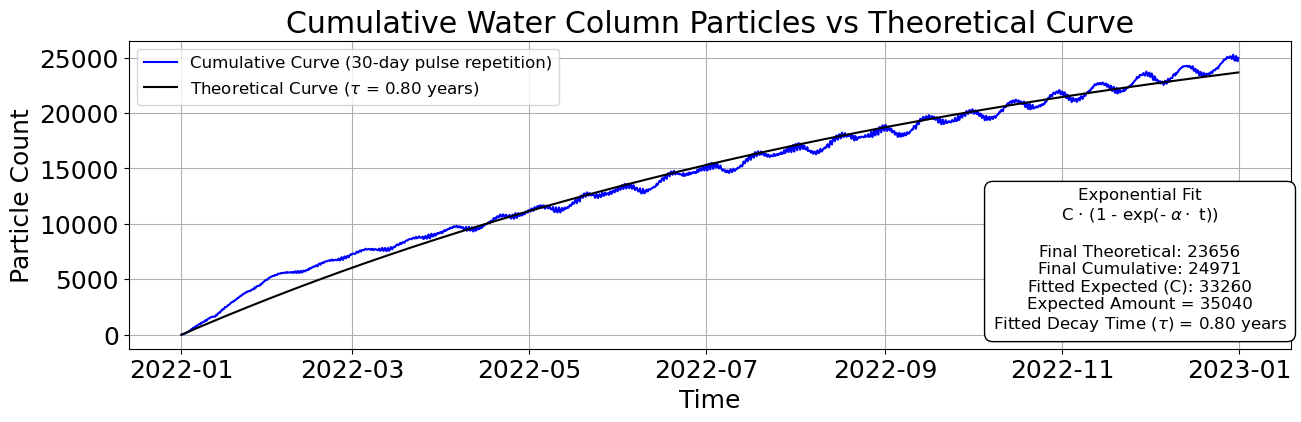

In [26]:
c_wc_AD3 = plot_cumulative_watercolumn_particles(filename = filename_AD3, release_freq=900, output_res=6, plot=True)

In [27]:
run_AD3 = proportions_from_filename(filename = filename_AD3)
#
table_AD3  = metrics_table(filename = filename_AD3, plot = False)
#
water_AD3, sediment_AD3 =  run_AD3['Sewage Water'] + run_AD3['Colloidal Water'] + run_AD3['Marine Water'] , run_AD3['Sewage Sediment'] + run_AD3['Colloidal Sediment'] + run_AD3['Marine Sediment']

/tmp/ipykernel_1881652/3796294218.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_1881652/3796294218.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_1881652/3796294218.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

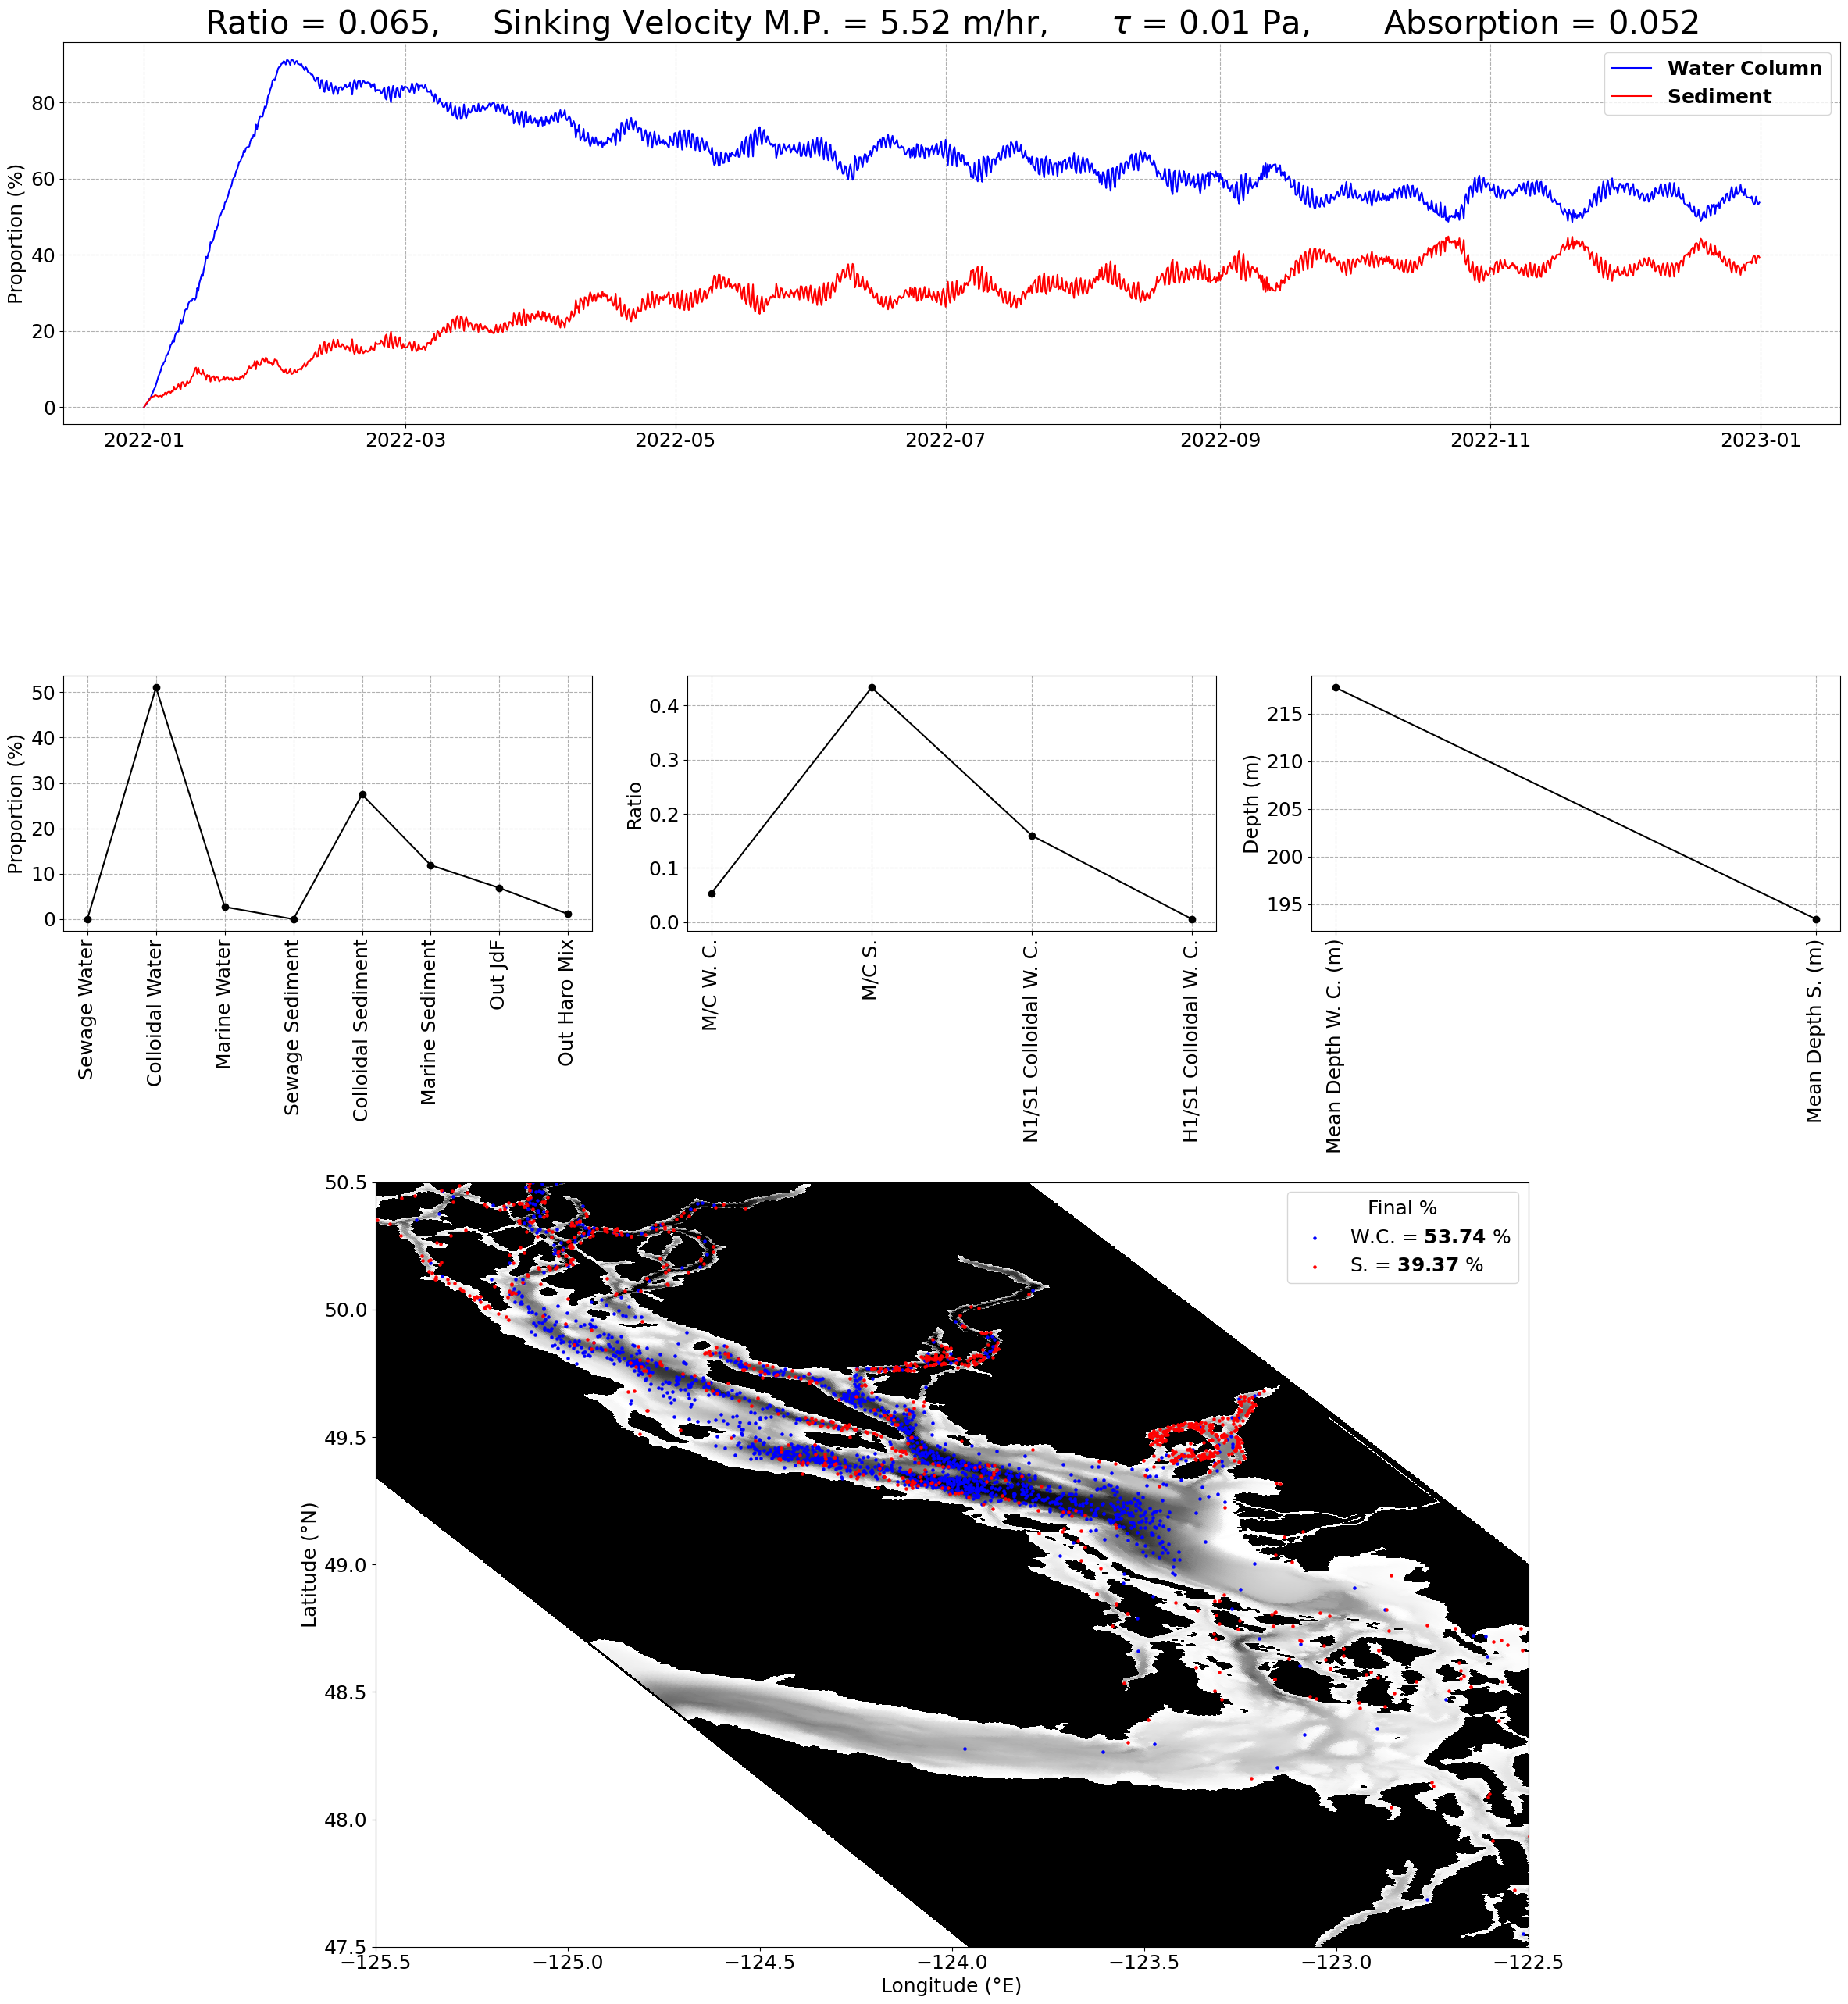

In [28]:
data_AD3 = xr.open_zarr(filename_AD3)
wc_AD3 = data_AD3.where((data_AD3.status < 4) & (data_AD3.status > 0))
sed_AD3 = data_AD3.where((data_AD3.status > 10))

#

plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water_AD3, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment_AD3, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.065,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.01 Pa,       Absorption = 0.052', fontsize = 30)

# Middle left
ax3.plot(run_AD3.columns[1:], run_AD3.iloc[-1][1:].values, '-o', color='k')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table_AD3.columns[1:5], table_AD3.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table_AD3.columns[-2:], table_AD3.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc_AD3.lon[:,-1], wc_AD3.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water_AD3[-1], 2)}}}\ \%$")
ax6.scatter(sed_AD3.lon[:,-1], sed_AD3.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment_AD3[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

In [3]:
filename_AD4 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_08_sv_5_AD_0_052.zarr'

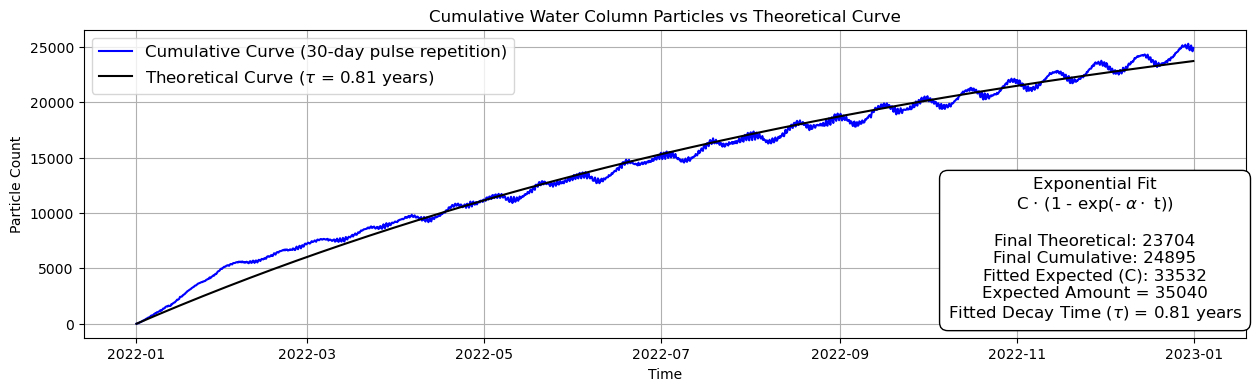

In [4]:
c_wc_AD4 = plot_cumulative_watercolumn_particles(filename = filename_AD4, release_freq=900, output_res=6, plot=True)

In [9]:
run_AD4 = proportions_from_filename(filename = filename_AD4)
#
table_AD4  = metrics_table(filename = filename_AD4, plot = False)
#
water_AD4, sediment_AD4 =  run_AD4['Sewage Water'] + run_AD4['Colloidal Water'] + run_AD4['Marine Water'] , run_AD4['Sewage Sediment'] + run_AD4['Colloidal Sediment'] + run_AD4['Marine Sediment']

/tmp/ipykernel_194698/2805545156.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_194698/2805545156.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_194698/2805545156.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

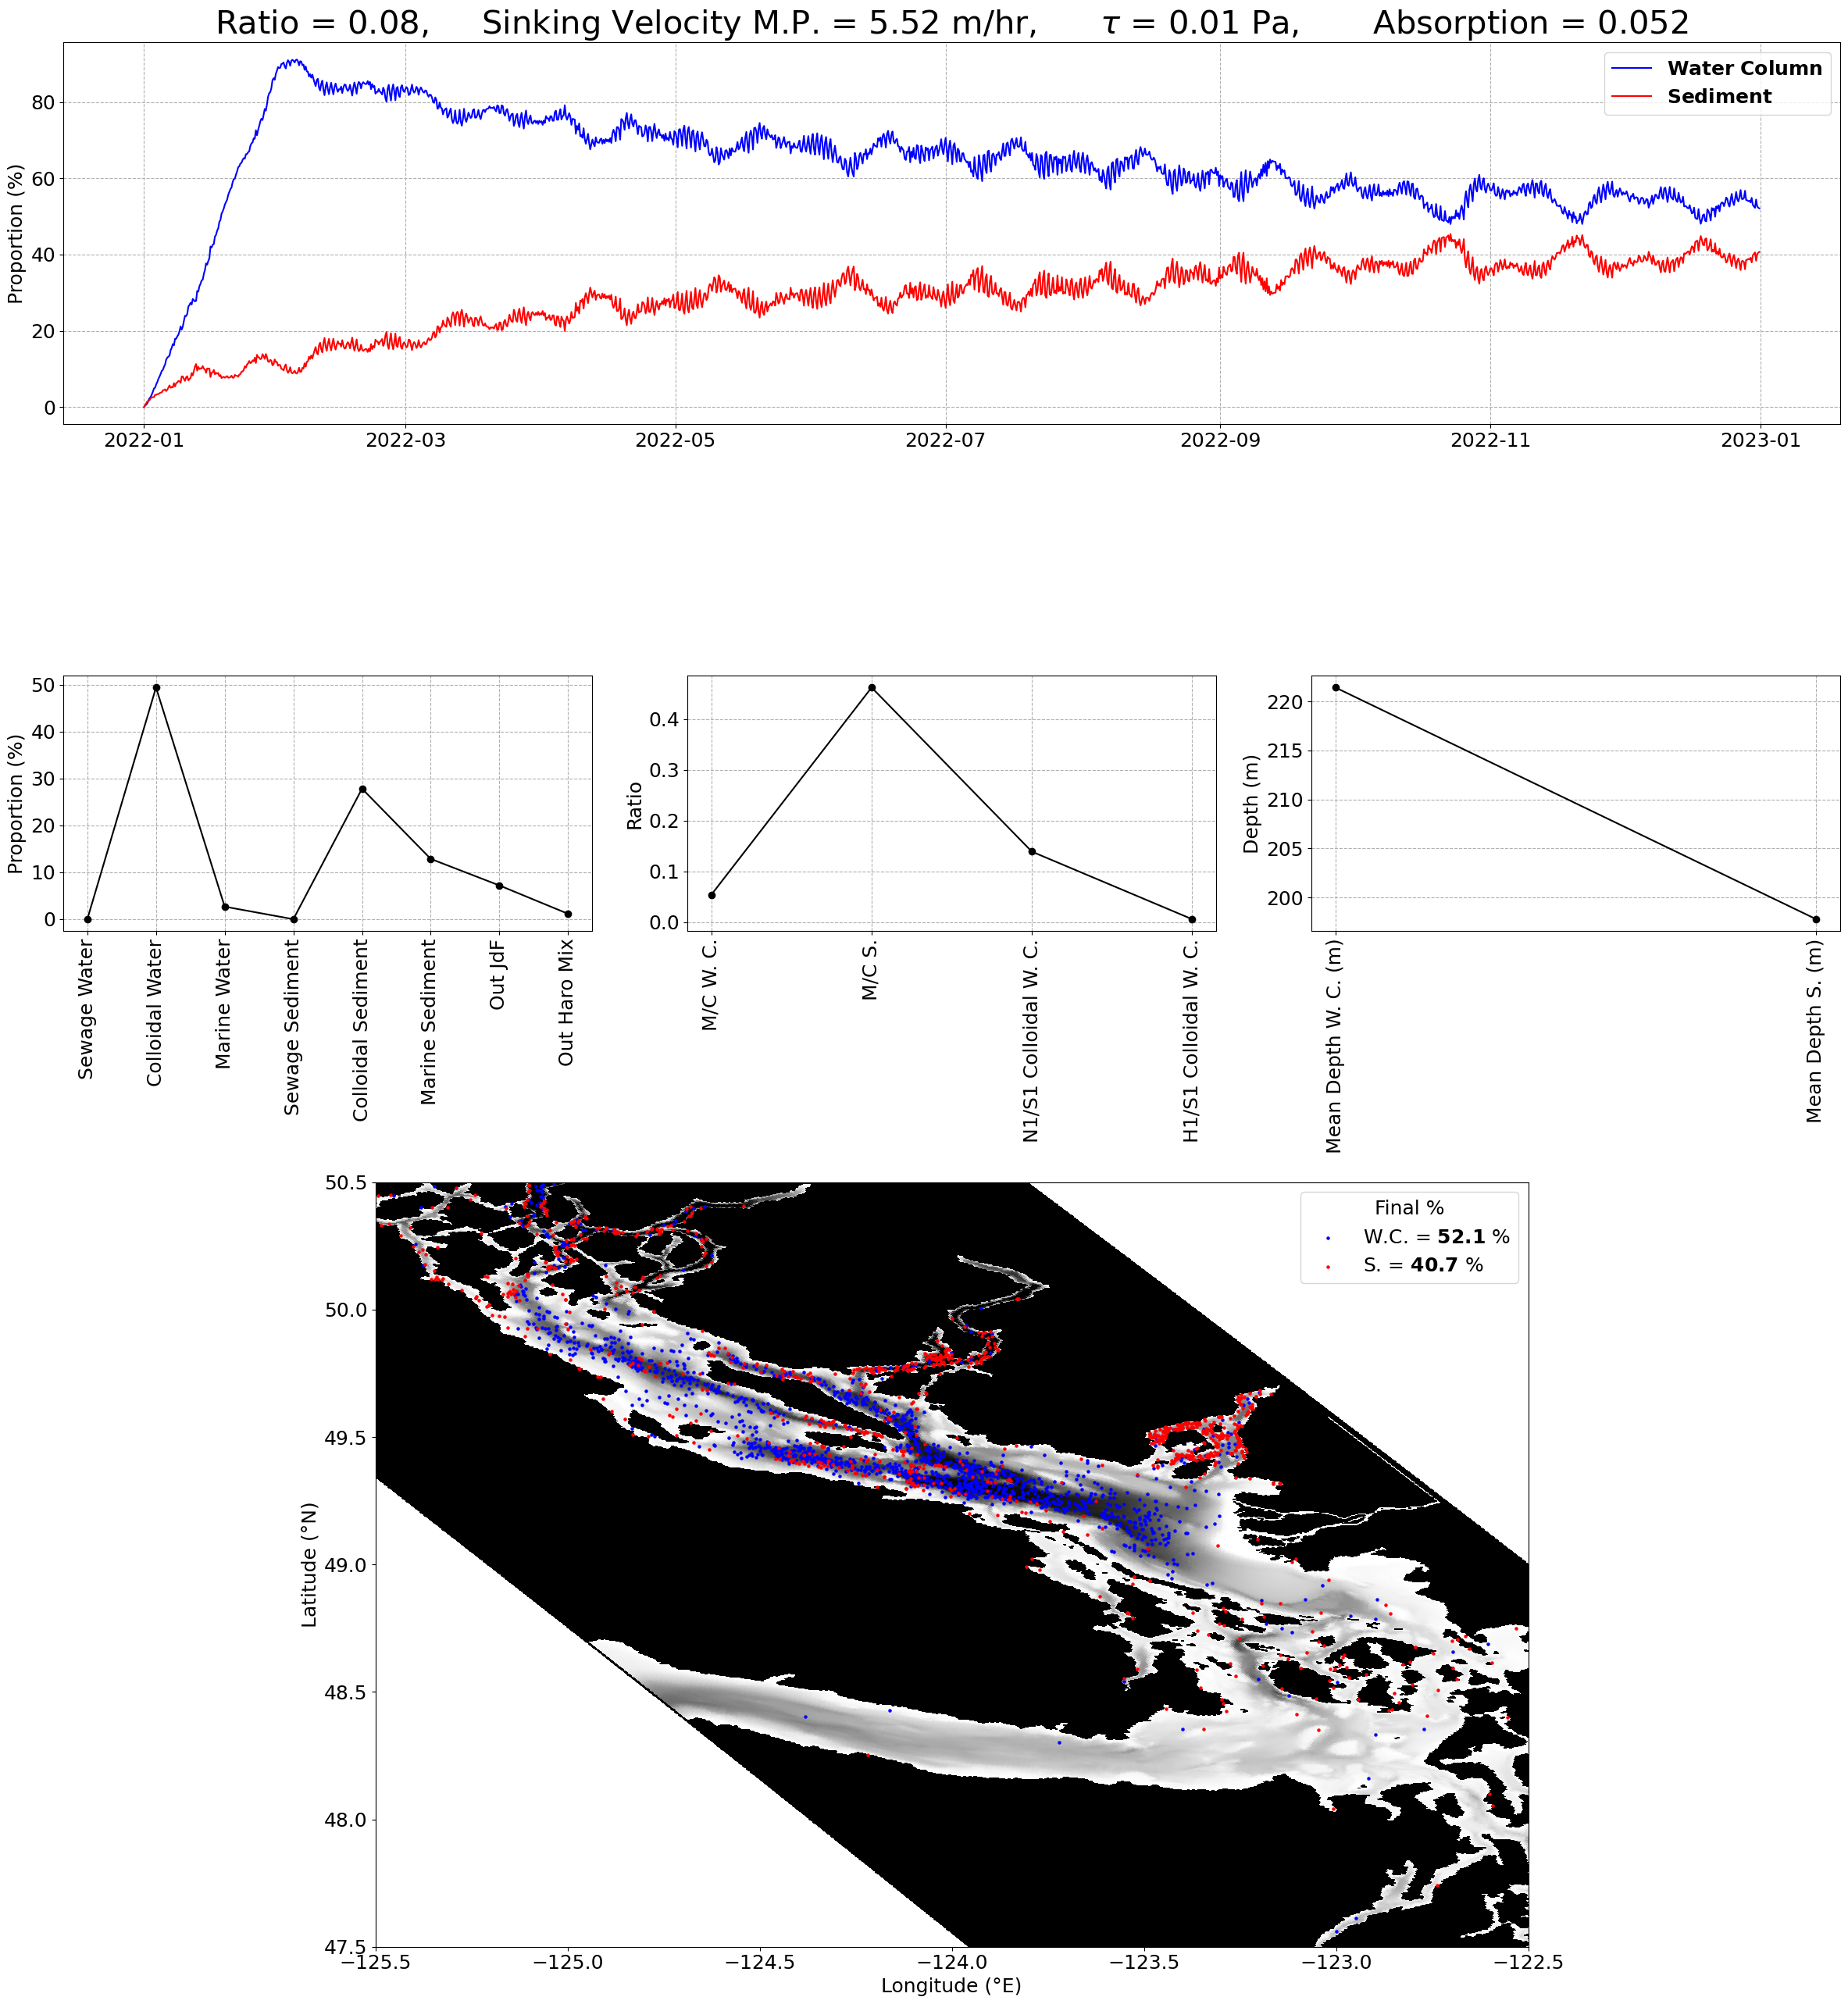

In [10]:
data_AD4 = xr.open_zarr(filename_AD4)
wc_AD4 = data_AD4.where((data_AD4.status < 4) & (data_AD4.status > 0))
sed_AD4 = data_AD4.where((data_AD4.status > 10))

#

plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water_AD4, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment_AD4, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.08,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.01 Pa,       Absorption = 0.052', fontsize = 30)

# Middle left
ax3.plot(run_AD4.columns[1:], run_AD4.iloc[-1][1:].values, '-o', color='k')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table_AD4.columns[1:5], table_AD4.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table_AD4.columns[-2:], table_AD4.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc_AD4.lon[:,-1], wc_AD4.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water_AD4[-1], 2)}}}\ \%$")
ax6.scatter(sed_AD4.lon[:,-1], sed_AD4.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment_AD4[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

In [5]:
filename_AD5 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_2_sv_5_AD_0_052.zarr'

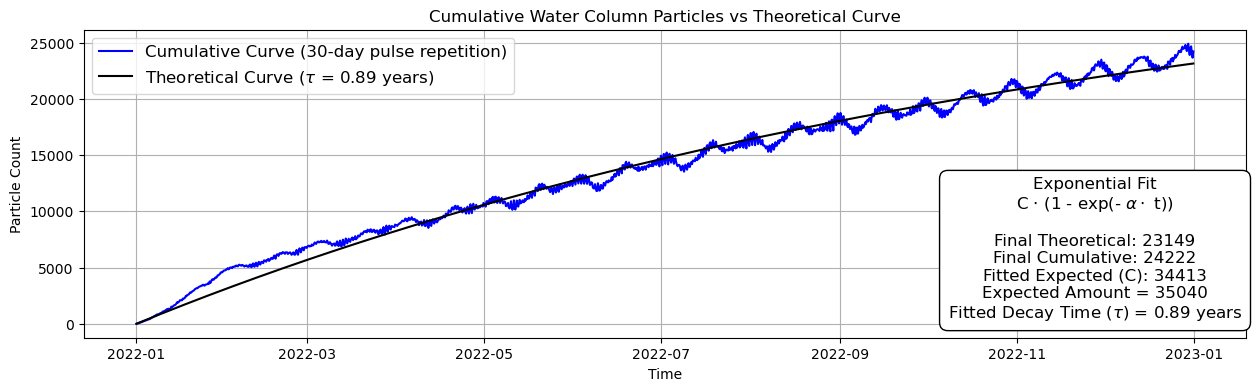

In [6]:
c_wc_AD5 = plot_cumulative_watercolumn_particles(filename = filename_AD5, release_freq=900, output_res=6, plot=True)

In [7]:
run_AD5 = proportions_from_filename(filename = filename_AD5)
#
table_AD5  = metrics_table(filename = filename_AD5, plot = False)
#
water_AD5, sediment_AD5 =  run_AD5['Sewage Water'] + run_AD5['Colloidal Water'] + run_AD5['Marine Water'] , run_AD5['Sewage Sediment'] + run_AD5['Colloidal Sediment'] + run_AD5['Marine Sediment']

/tmp/ipykernel_2569955/562860203.py:64: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
/tmp/ipykernel_2569955/562860203.py:65: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
/tmp/ipykernel_2569955/562860203.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

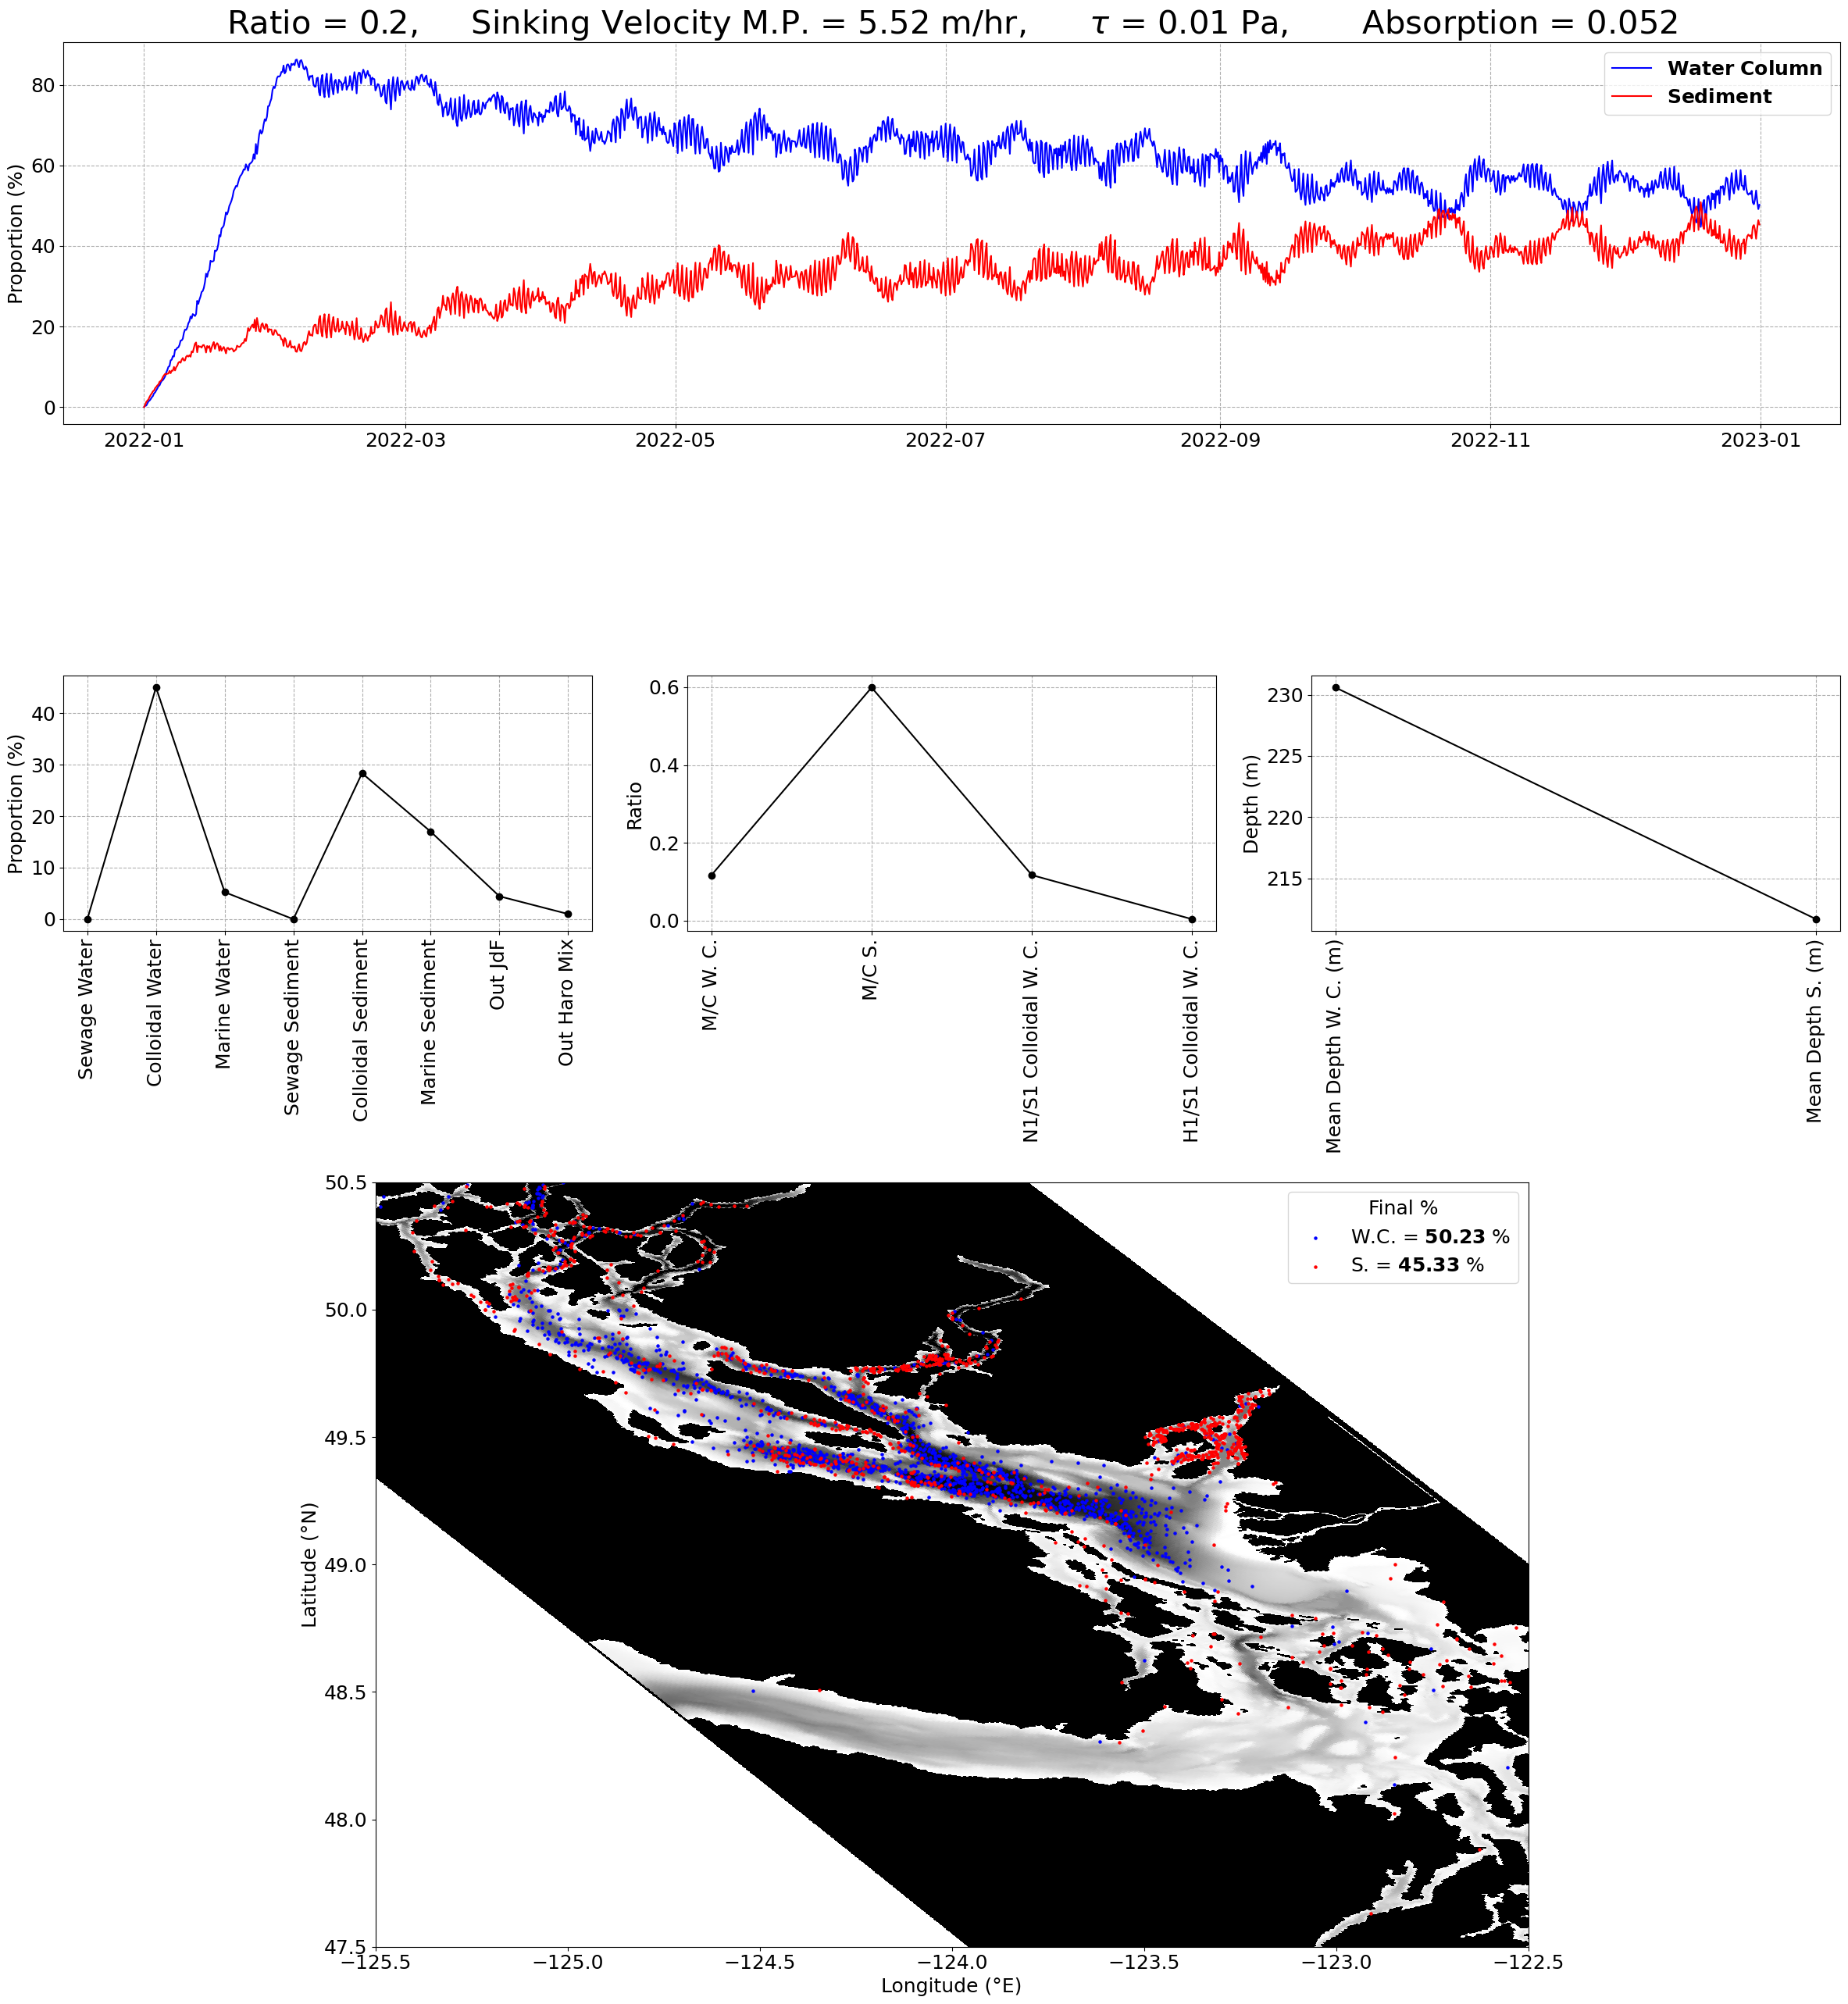

In [9]:
data_AD5 = xr.open_zarr(filename_AD5)
wc_AD5 = data_AD5.where((data_AD5.status < 4) & (data_AD5.status > 0))
sed_AD5 = data_AD5.where((data_AD5.status > 10))

#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
#
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 18})

# Create custom GridSpec: 3 rows, 6 columns
fig = plt.figure(figsize=(24, 26))
gs = gridspec.GridSpec(3, 6, height_ratios=[1.5, 1, 3])

# === Top row (2 panels) ===
ax1 = fig.add_subplot(gs[0, 0:6])

# === Middle row (3 panels) ===
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# === Bottom row (3 spatial maps) ===
ax6 = fig.add_subplot(gs[2, 1:5])


# === Plotting ===

# Top left
ax1.plot(water_AD5, 'b', label=rf"$\bf{{Water}}$ $\bf{{Column}}$")
ax1.plot(sediment_AD5, 'r', label=rf"$\bf{{Sediment}}$")

ax1.grid(linestyle='--')
ax1.legend()
ax1.set_ylabel('Proportion (%)')
ax1.set_title(r'Ratio = 0.2,     Sinking Velocity M.P. = 5.52 m/hr,      $\tau$ = 0.01 Pa,       Absorption = 0.052', fontsize = 30)

# Middle left
ax3.plot(run_AD5.columns[1:], run_AD5.iloc[-1][1:].values, '-o', color='k')
ax3.grid(linestyle='--')
ax3.tick_params(axis='x', rotation=90)
ax3.set_ylabel('Proportion (%)')

# Middle center
ax4.plot(table_AD5.columns[1:5], table_AD5.loc[0].values[1:5], '-o', color='k')

ax4.grid(linestyle='--')
ax4.tick_params(axis='x', rotation=90)
ax4.set_ylabel('Ratio')

# Middle right
ax5.plot(table_AD5.columns[-2:], table_AD5.loc[0].values[-2:], '-o', color='k')

ax5.grid(linestyle='--')
ax5.tick_params(axis='x', rotation=90)
ax5.set_ylabel('Depth (m)')

# === Spatial patterns ===

# Map 1
ax6.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys')
ax6.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)
ax6.scatter(wc_AD5.lon[:,-1], wc_AD5.lat[:,-1], c='b', s=5, label=rf"W.C. = $\mathbf{{{np.round(water_AD5[-1], 2)}}}\ \%$")
ax6.scatter(sed_AD5.lon[:,-1], sed_AD5.lat[:,-1], c='r', s=5, label=rf"S. = $\mathbf{{{np.round(sediment_AD5[-1], 2)}}}\ \%$")
ax6.set_xlim([-124 - 1.5, -124 + 1.5])
ax6.set_ylim([49 - 1.5, 49 + 1.5])
ax6.set_ylabel('Latitude (°N)')
ax6.set_xlabel('Longitude (°E)')
ax6.legend(title = 'Final %')

# Final layout
plt.tight_layout()
plt.show()

# Multiple restart files from AD5 simulation

In [2]:
def plot_cumulative_watercolumn_particles_multiple(files, release_freq, output_res, n, plot=True):
    """
    files: list of zarr file paths, ordered chronologically (e.g., [year1, year2])
    release_freq: in seconds (e.g., 3600 for hourly)
    output_res: in hours (e.g., 1 for hourly)
    """
    cumulative_all = []
    start_time = None
    total_steps = 0

    for file in files:
        data = xr.open_dataset(file, engine='zarr')
        if start_time is None:
            time = data.time[0, 0].values
            start_time = pd.to_datetime(time)

        go_back = data.status.shape[1]
        number_in_watercolumn = np.zeros(go_back)

        for it in range(go_back):
            positive = data.status[:, it][data.status[:, it] > 0]
            number_in_watercolumn[it] = positive.values[positive.values < 4].shape[0]

        cumulative_all.append(number_in_watercolumn)
        total_steps += go_back

    # Combine particle counts from all files
    number_in_watercolumn_all = np.concatenate(cumulative_all)

    # Create unified time index
    time_index = pd.date_range(start=start_time, periods=total_steps, freq=f'{output_res}h')

    # Pulse accumulation every 30 days
    steps_per_day = int(24 / output_res)
    steps_30_days = 30 * steps_per_day

    cumulative = np.copy(number_in_watercolumn_all)
    for i in range(0, total_steps, steps_30_days):
        pulse_len = total_steps - i
        cumulative[i:] += number_in_watercolumn_all[:pulse_len]

    # Exponential model
    def exp_model(t, C0, time_decay):
        alpha = 1 / (time_decay * 365 * 86400 / (3600 * output_res))
        return C0 * (1 - np.exp(-alpha * t))

    tt = np.arange(total_steps)
    popt, _ = curve_fit(exp_model, tt, cumulative, p0=[1.0, 1.0])
    C0_fit, decay_fit = popt
    y_fit = exp_model(tt, C0_fit, decay_fit)

    # Theoretical total
    C = (n * 365 * 86400) / release_freq

    # DataFrame output
    df_out = pd.DataFrame({
        'goal': y_fit,
        'cumulative': cumulative
    }, index=time_index)
    df_out.index.name = 'datetime'

    # Plotting
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(15, 4))
        ax.plot(df_out.index, df_out['cumulative'], 'b', label='Cumulative Curve (30-day pulse repetition)')
        ax.plot(df_out.index, df_out['goal'], 'k', label=rf'Theoretical Curve ($\tau$ = {decay_fit:.2f} years)')
        ax.set_title('Cumulative Water Column Particles vs Theoretical Curve (Multi-Year)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Particle Count')
        ax.grid()
        ax.legend(loc='upper left', fontsize=12)

        textstr = (
            f"Exponential Fit\n"
            f"C $\\cdot$ (1 - exp(- $\\alpha \\cdot$ t))\n"
            f"\n"
            f"Final Theoretical: {int(y_fit[-1])}\n"
            f"Final Cumulative: {int(cumulative[-1])}\n"
            f"Fitted Expected (C): {int(C0_fit)}\n"
            f"Expected Amount = {int(C)}\n"
            f"Fitted Decay Time ($\\tau$) = {decay_fit:.2f} years"
        )
        ax.text(0.87, 0.05, textstr,
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), ha='center')

    return df_out


Continue with AD5 run to 2nd year simulation :D

In [3]:
filename_AD5 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_2_sv_5_AD_0_052.zarr'
filename_2ndy = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/RESTART_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_2_sv_5_AD_0_052_restart_365_days_continue_to_2nd_year_same_as_best_run.zarr'
filename_3ndy = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/RESTART_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_2_sv_5_AD_0_052_restart_365_days_continue_to_2nd_year_same_as_best_run_restart_365_days_3rd_year.zarr'
filenames_3years = [filename_AD5, filename_2ndy, filename_3ndy]

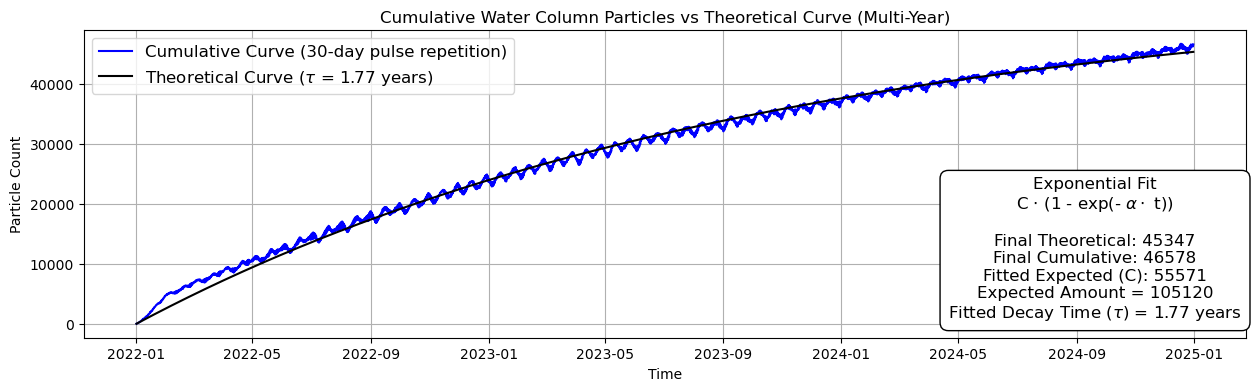

In [4]:
c_wc_2ndy = plot_cumulative_watercolumn_particles_multiple(files = filenames_3years, release_freq=900, output_res=6, n = 3, plot=True)

Full year particles release

In [9]:
filename_full = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_release_run_tau_0_01_ratio_0_2_sv_5_AD_0_052.zarr'